# Task 1 : Exploratory Data Analysis (EDA)

### Importing requried libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
from watermark  import watermark

In [2]:
sys.path.insert(0, os.path.abspath('..'))
from latexify import latexify, format_axes
latexify()

# Retina mode
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Print package versions

In [3]:
%reload_ext watermark
%watermark -a "E. Díaz" -u -n -t -z -m -v -p numpy,pandas,matplotlib,sklearn,seaborn

Author: E. Díaz

Last updated: Wed Aug 28 2024 00:21:27India Standard Time

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

numpy     : 2.0.1
pandas    : 2.2.2
matplotlib: 3.9.2
sklearn   : 1.5.1
seaborn   : 0.13.2

Compiler    : MSC v.1940 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 186 Stepping 2, GenuineIntel
CPU cores   : 20
Architecture: 64bit



### Load the training and testing data

In [4]:
X_train = np.load('../Saved_Datasets/Raw_Acc_Data/X_train.npy')
X_test = np.load('../Saved_Datasets/Raw_Acc_Data/X_test.npy')
y_train = np.load('../Saved_Datasets/Raw_Acc_Data/y_train.npy')
y_test = np.load('../Saved_Datasets/Raw_Acc_Data/y_test.npy')

print("Training data shape: ",X_train.shape)
print("Training labels shape: ",y_train.shape)
print("Testing data shape: ",X_test.shape)
print("Testing labels shape: ",y_test.shape)

Training data shape:  (126, 500, 3)
Training labels shape:  (126,)
Testing data shape:  (54, 500, 3)
Testing labels shape:  (54,)


### Data Cleaning

Remove duplicate and Null/NAN values

In [5]:
def duplicates(data):
    return len(data) - len(np.unique(data, axis=0))

print("Number of duplicated samples in training data: ", duplicates(X_train))
print("Number of duplicated samples in testing data: ", duplicates(X_test))

print("\nNumber of NaN/Null values in training data: ", np.isnan(X_train).sum())
print("Number of NaN/Null values in testing data: ", np.isnan(X_test).sum())

Number of duplicated samples in training data:  0
Number of duplicated samples in testing data:  0

Number of NaN/Null values in training data:  0
Number of NaN/Null values in testing data:  0


## Question 1

Q1. Plot the waveform for one sample data from each activity class. Are you able to see any difference/similarities between the activities? You can plot a subplot having 6 columns to show differences/similarities between the activities. Do you think the model will be able to classify the activities based on the data?

### Solution:

The following 6x3 subplot shows the accelerometer data for the first subject from training data:

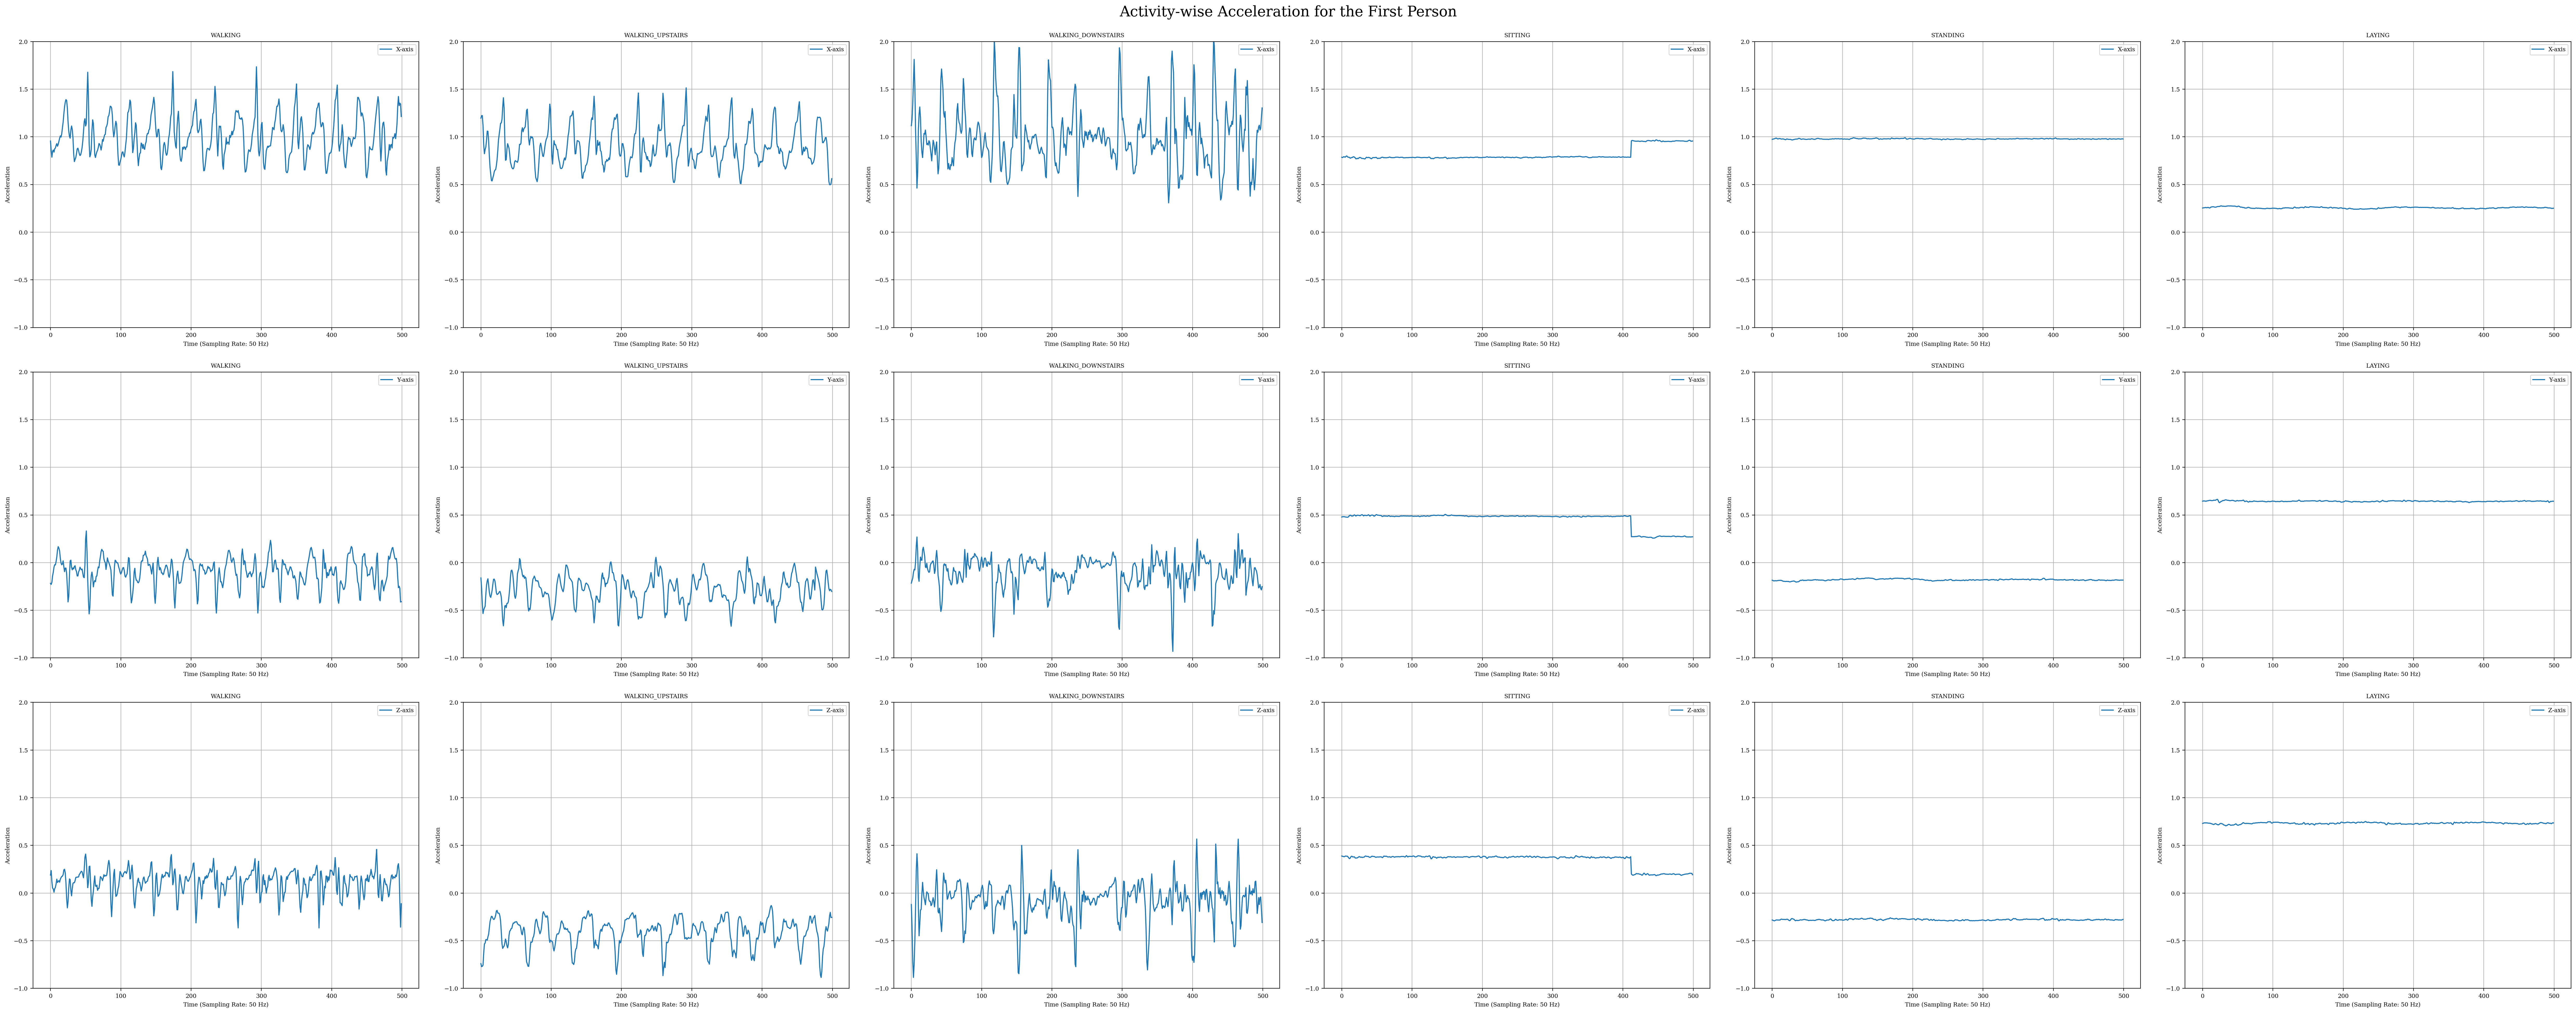

In [6]:
activity_classes = {"WALKING":1,"WALKING_UPSTAIRS":2,"WALKING_DOWNSTAIRS":3,"SITTING":4,"STANDING":5,"LAYING":6}
directions = ["X-axis","Y-axis","Z-axis"]

standard_color = 'tab:blue'
fig, axes = plt.subplots(3, 6, figsize=(50,20))
fig.suptitle("Activity-wise Acceleration for the First Person", fontsize=20)

for activity_class, i in activity_classes.items():
    acc_data = X_train[y_train==i]   # get the accelerometer data for the class
    acc_data_p1 = acc_data[0]        # get the accelerometer data for the first person

    for j, direction in enumerate(directions):
        axes[j,i-1].set_title(activity_class)
        axes[j,i-1].plot(acc_data_p1[:,j], label=direction)
        axes[j,i-1].legend()
        axes[j,i-1].set_xlabel("Time (Sampling Rate: 50 Hz)")
        axes[j,i-1].set_ylabel("Acceleration")
        axes[j,i-1].set_ylim(-1, 2) # setting y limit so that graphs are comparable for better visualization
        axes[j,i-1].grid()

plt.tight_layout(pad=3.0)
plt.show()

We observe that different activities exhibit noticeable differences in their directional waveforms. The range of acceleration and the frequency of peaks vary across the activities.

In the plots, walking, walking upstairs, and walking downstairs show multiple peaks in their waveforms, whereas activities like standing, sitting, and laying have much smoother waveforms. This smoother pattern occurs because the person isn’t moving much, so the acceleration remains relatively constant. Therefore, it is possible to distinguish between static and dynamic activities just by observing these graphs. However, differentiating between individual activities within the dynamic or static categories by simply looking at the graphs is challenging.

When using a decision tree on raw time-series data, the model may not perform well. This is because the model considers the acceleration at each point in time as a feature and attempts to use that value to decide the split. However, if the waveform is time-shifted, the value at a particular time changes, which could lead to a completely different prediction. Since decision tree models do not account for the order of data, which is crucial for understanding the activities, their performance might be poor.

However, if we transform this data into features such as `mean_acc_x` and `std_dev_x`, we may have a better chance at classifying the activities. For instance, the model could more easily distinguish between static and dynamic activities by examining the standard deviation in any axis. While we may observe patterns in dynamic activities like walking, it may still be challenging to differentiate between walking and walking upstairs, as both are dynamic and have similar waveforms.

## Question 2

Q2. Do you think we need a machine learning model to differentiate between static activities (laying, sitting, standing) and dynamic activities(walking, walking_downstairs, walking_upstairs)? Look at the linear acceleration $(acc_x^2+acc_y^2+acc_z^2)$ for each activity and justify your answer.


### Solution:

We can find the linear acceleration $(acc_x^2 + acc_y^2 + acc_z^2)$ for each activity in the following manner:

Linear Acceleration Training Data Shape:  (126, 500)
Linear Acceleration Testing Data Shape:  (54, 500)
Linear acceleration data for subject 1


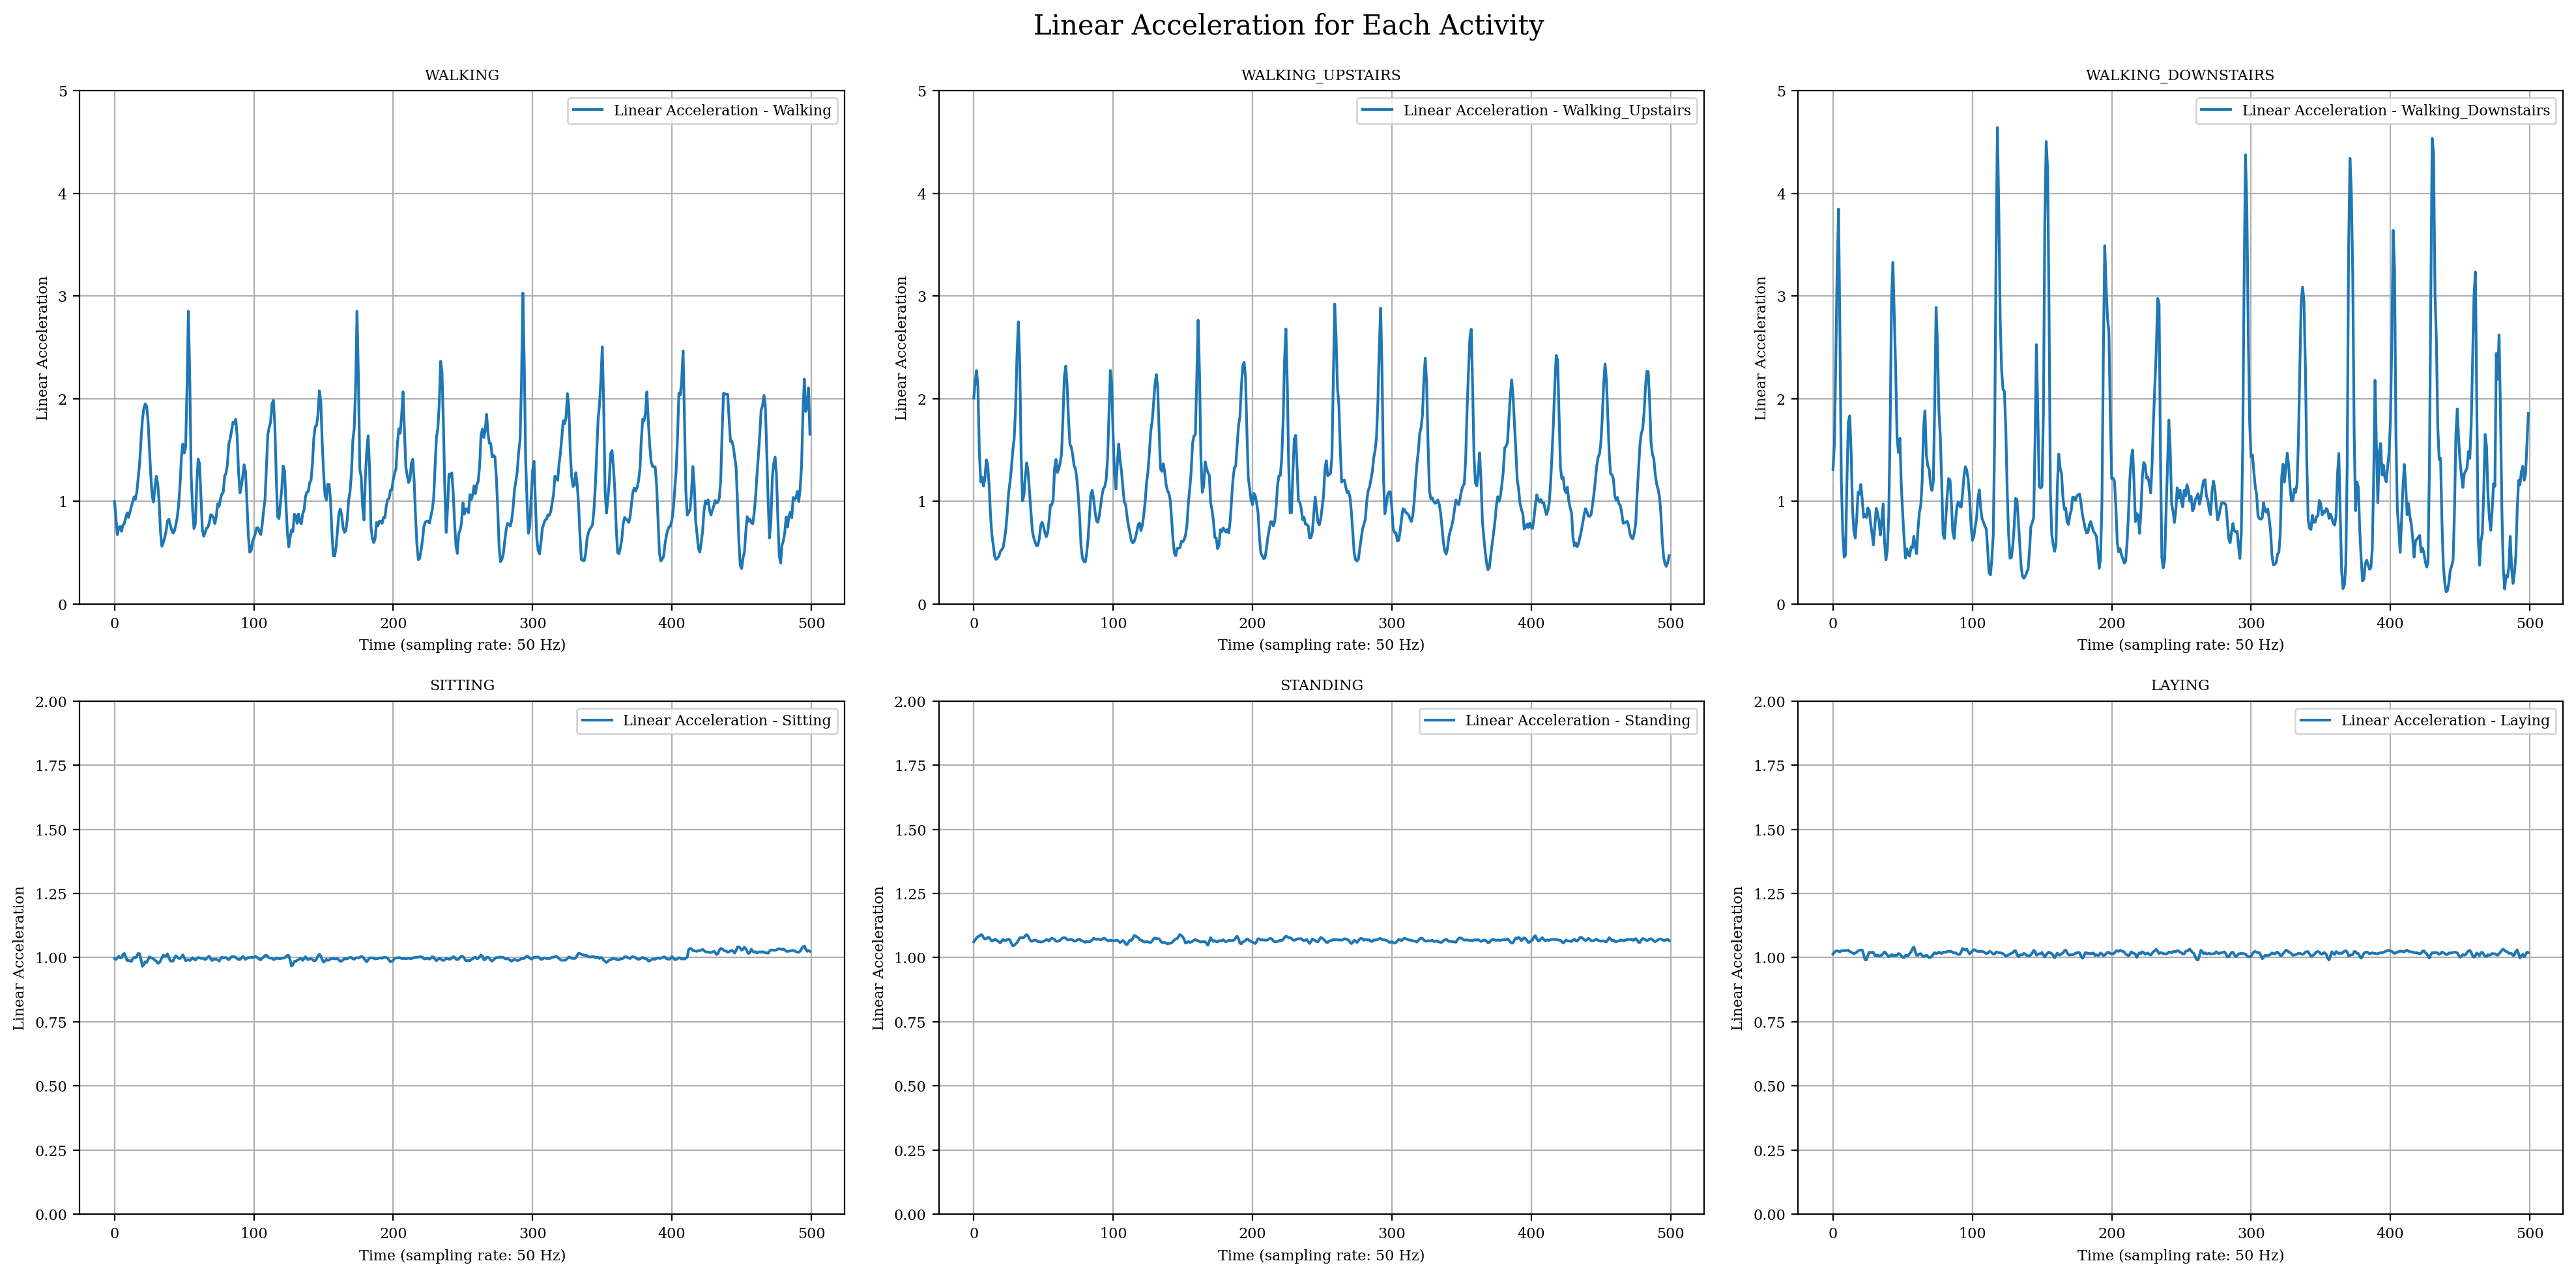

Linear acceleration data for subject 2


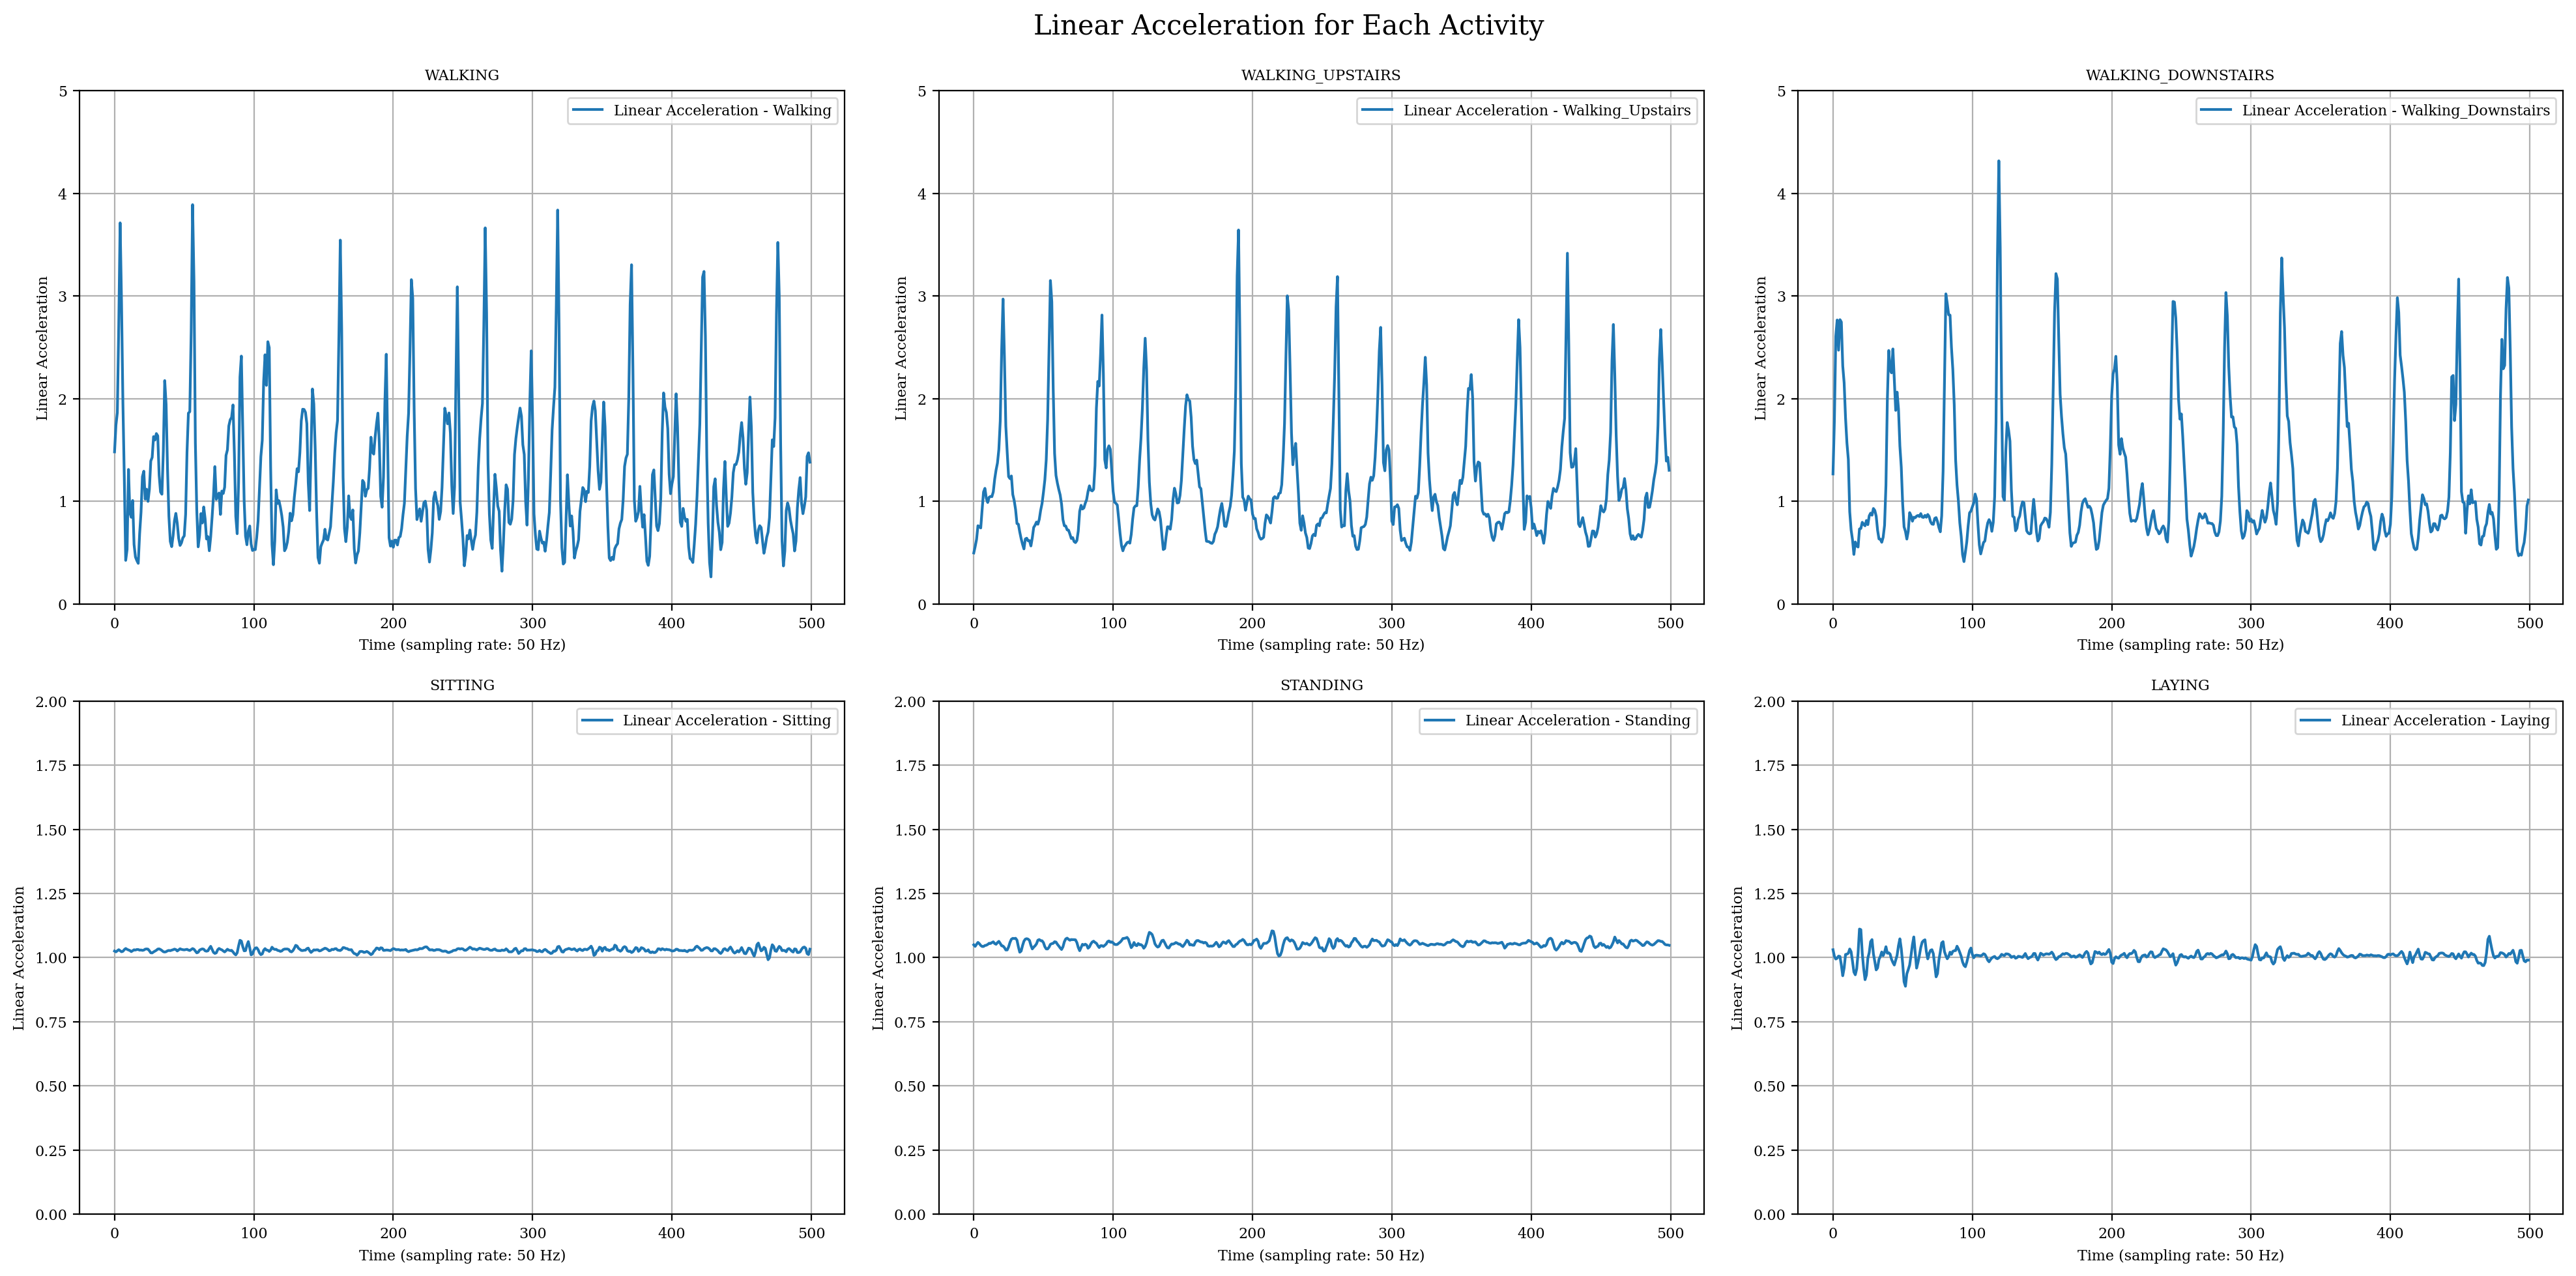

In [7]:
# calculates linear acceleration for training and testing data
linear_acceleration_train = X_train[:,:,0]**2 + X_train[:,:,1]**2 + X_train[:,:,2]**2
linear_acceleration_test = X_test[:,:,0]**2 + X_test[:,:,1]**2 + X_test[:,:,2]**2
print("Linear Acceleration Training Data Shape: ", linear_acceleration_train.shape)
print("Linear Acceleration Testing Data Shape: ", linear_acceleration_test.shape)

def plot_linear_acceleration(activity_classes, linear_acceleration_train, y_train, subject_id):
    print("="*150)
    print("Linear acceleration data for subject", subject_id)
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle("Linear Acceleration for Each Activity", fontsize=15)
    axes = axes.flatten()

    for activity_class, i in activity_classes.items():
        acceleration_data = linear_acceleration_train[y_train == i][subject_id-1]

        ax = axes[i-1]
        ax.plot(acceleration_data, label=f'Linear Acceleration - {str.title(activity_class)}')
        ax.set_title(f'{activity_class}')
        ax.set_xlabel('Time (sampling rate: 50 Hz)')
        ax.set_ylabel('Linear Acceleration')
        # Set the y-axis limits for better visualization
        if i<4:
            ax.set_ylim(0, 5)
        else:
            ax.set_ylim(0, 2)          
        ax.legend()
        ax.grid()

    plt.tight_layout(pad=2.0)
    plt.show()


# Plot linear acceleration for the first person
plot_linear_acceleration(activity_classes, linear_acceleration_train, y_train, 1)

# Plot linear acceleration for the second person
plot_linear_acceleration(activity_classes, linear_acceleration_train, y_train, 2)


No, we don't need a machine learning model to differentiate between static activities (laying, sitting, standing) and dynamic activities (walking, walking downstairs, walking upstairs).
We can visually distinguish between static and dynamic activities by looking at the minimum and maximum values of linear acceleration in the graphs. <br>
The linear acceleration for static activities is almost constant at around 1(1g), while for dynamic activities, it continuously varies with higher peaks. Thus , we can predict the activity using simple conditional statements based on the maximum and minimum acceleration values whether an activity is static or dynamic.


## Question 3

Q3. Visualize the data using PCA.

1. Use PCA (Principal Component Analysis) on Total Acceleration $(acc_x^2+acc_y^2+acc_z^2)$ to compress the acceleration timeseries into two features and plot a scatter plot to visualize different class of activities.

2.  Next, use [TSFEL](https://tsfel.readthedocs.io/en/latest/) ([a featurizer library](https://github.com/fraunhoferportugal/tsfel)) to create features (your choice which ones you feel are useful) and then perform PCA to obtain two features. Plot a scatter plot to visualize different class of activities.

3.  Now use the features provided by the dataset and perform PCA to obtain two features. Plot a scatter plot to visualize different class of activities.

4.  Compare the results of PCA on Total Acceleration, TSFEL and the dataset features. Which method do you think is better for visualizing the data? 

**Solution:**

Importing the StandardScaler() and PCA() functions from scikit-learn.

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#### 3.1 Using PCA (Principal Component Analysis) on Total Acceleration to compress the acceleration timeseries into two features and plot a scatter plot to visualize different class of activities.

Shape of the original data:  (126, 500)
Shape of the data after applying PCA:  (126, 2)


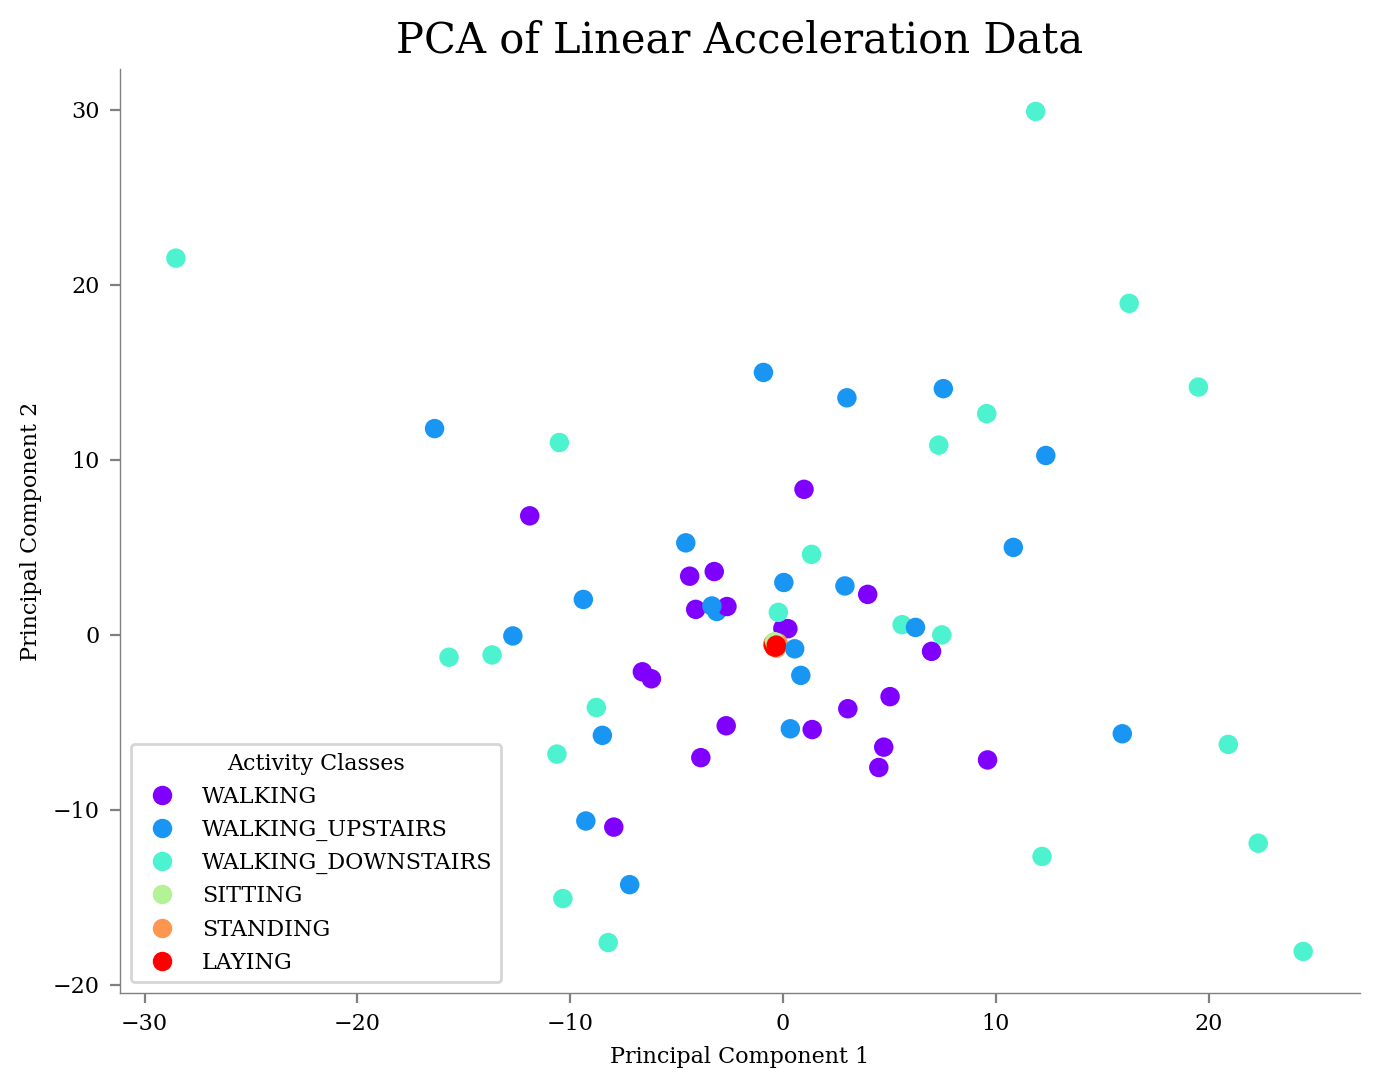

In [9]:
# standardizing the data before applying PCA
acc_scaler = StandardScaler()
linear_acceleration_train_scaled = acc_scaler.fit_transform(linear_acceleration_train)

# applying PCA
acc_pca = PCA(n_components=2)
linear_acceleration_train_pca = acc_pca.fit_transform(linear_acceleration_train_scaled)

print("Shape of the original data: ", linear_acceleration_train.shape)
print("Shape of the data after applying PCA: ", linear_acceleration_train_pca.shape)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(linear_acceleration_train_pca[:, 0], linear_acceleration_train_pca[:, 1], c=y_train, cmap='rainbow')
format_axes(plt.gca())
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Linear Acceleration Data", fontsize=15)
plt.legend(handles=scatter.legend_elements()[0], labels=activity_classes.keys(), title="Activity Classes")

if not os.path.exists('./Saved_Images'):
    os.makedirs('./Saved_Images')
plt.savefig('./Saved_Images/PCA_Linear_Acceleration.png', bbox_inches='tight', dpi=300)
plt.show()


#### 3.2 Using [TSFEL](https://tsfel.readthedocs.io/en/latest/) to extract features from the raw accelerometer data.Performing PCA on these features to obtain 2 principle features and then plot them using a scatter plot to visualize different classes of activies

In [10]:
import tsfel

# Extract features using TSFEL
cfg = tsfel.get_features_by_domain()  # Get all features by default
X_train_tsfel = tsfel.time_series_features_extractor(cfg, X_train, verbose=1,fs =50)# extracts features from time series data
X_test_tsfel = tsfel.time_series_features_extractor(cfg, X_test, verbose=1,fs =50)

print("Shape of train data after performing feature creation using tsfel:",X_train_tsfel.shape)
print("Shape of test data after performing feature creation using tsfel:",X_test_tsfel.shape)
print(X_train_tsfel.columns)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
Shape of train data after performing feature creation using tsfel: (126, 1152)
Shape of test data after performing feature creation using tsfel: (54, 1152)
Index(['0_Absolute energy', '0_Area under the curve', '0_Autocorrelation',
       '0_Average power', '0_Centroid', '0_ECDF Percentile Count_0',
       '0_ECDF Percentile Count_1', '0_ECDF Percentile_0',
       '0_ECDF Percentile_1', '0_ECDF_0',
       ...
       '2_Wavelet variance_0', '2_Wavelet variance_1', '2_Wavelet variance_2',
       '2_Wavelet variance_3', '2_Wavelet variance_4', '2_Wavelet variance_5',
       '2_Wavelet variance_6', '2_Wavelet variance_7', '2_Wavelet variance_8',
       '2_Zero crossing rate'],
      dtype='object', length=1152)


In [11]:
from sklearn.feature_selection import VarianceThreshold

# Highly correlated features are removed
corr_features = tsfel.correlated_features(X_train_tsfel, threshold=0.95)
X_train_tsfel_corr = X_train_tsfel.drop(corr_features, axis=1)
X_test_tsfel_corr = X_test_tsfel.drop(corr_features, axis=1)
print("Shape of train data after removing correlated features:",X_train_tsfel_corr.shape)
print("Shape of test data after removing correlated features:",X_test_tsfel_corr.shape)

# Remove low variance features
selector = VarianceThreshold(threshold = 0.1) # default is 0
X_train_tsfel_corr_var = selector.fit_transform(X_train_tsfel_corr)
X_test_tsfel_corr_var = selector.transform(X_test_tsfel_corr)
print("\nShape of train data after removing low variance features:",X_train_tsfel_corr_var.shape)
print("Shape of test data after removing low variance features:",X_test_tsfel_corr_var.shape)

Shape of train data after removing correlated features: (126, 844)
Shape of test data after removing correlated features: (54, 844)

Shape of train data after removing low variance features: (126, 116)
Shape of test data after removing low variance features: (54, 116)


In [12]:
# Normalising Features
tsfel_scaler = StandardScaler()
X_train_tsfel_scaled = tsfel_scaler.fit_transform(X_train_tsfel_corr_var)
X_test_tsfel_scaled = tsfel_scaler.transform(X_test_tsfel_corr_var)

# Applying PCA
tsfel_pca = PCA(n_components=2)
X_train_tsfel_pca = tsfel_pca.fit_transform(X_train_tsfel_scaled)
X_test_tsfel_pca = tsfel_pca.transform(X_test_tsfel_scaled)

print("Training data shape after PCA: ",X_train_tsfel_pca.shape)
print("Testing data shape after PCA: ",X_test_tsfel_pca.shape)

Training data shape after PCA:  (126, 2)
Testing data shape after PCA:  (54, 2)


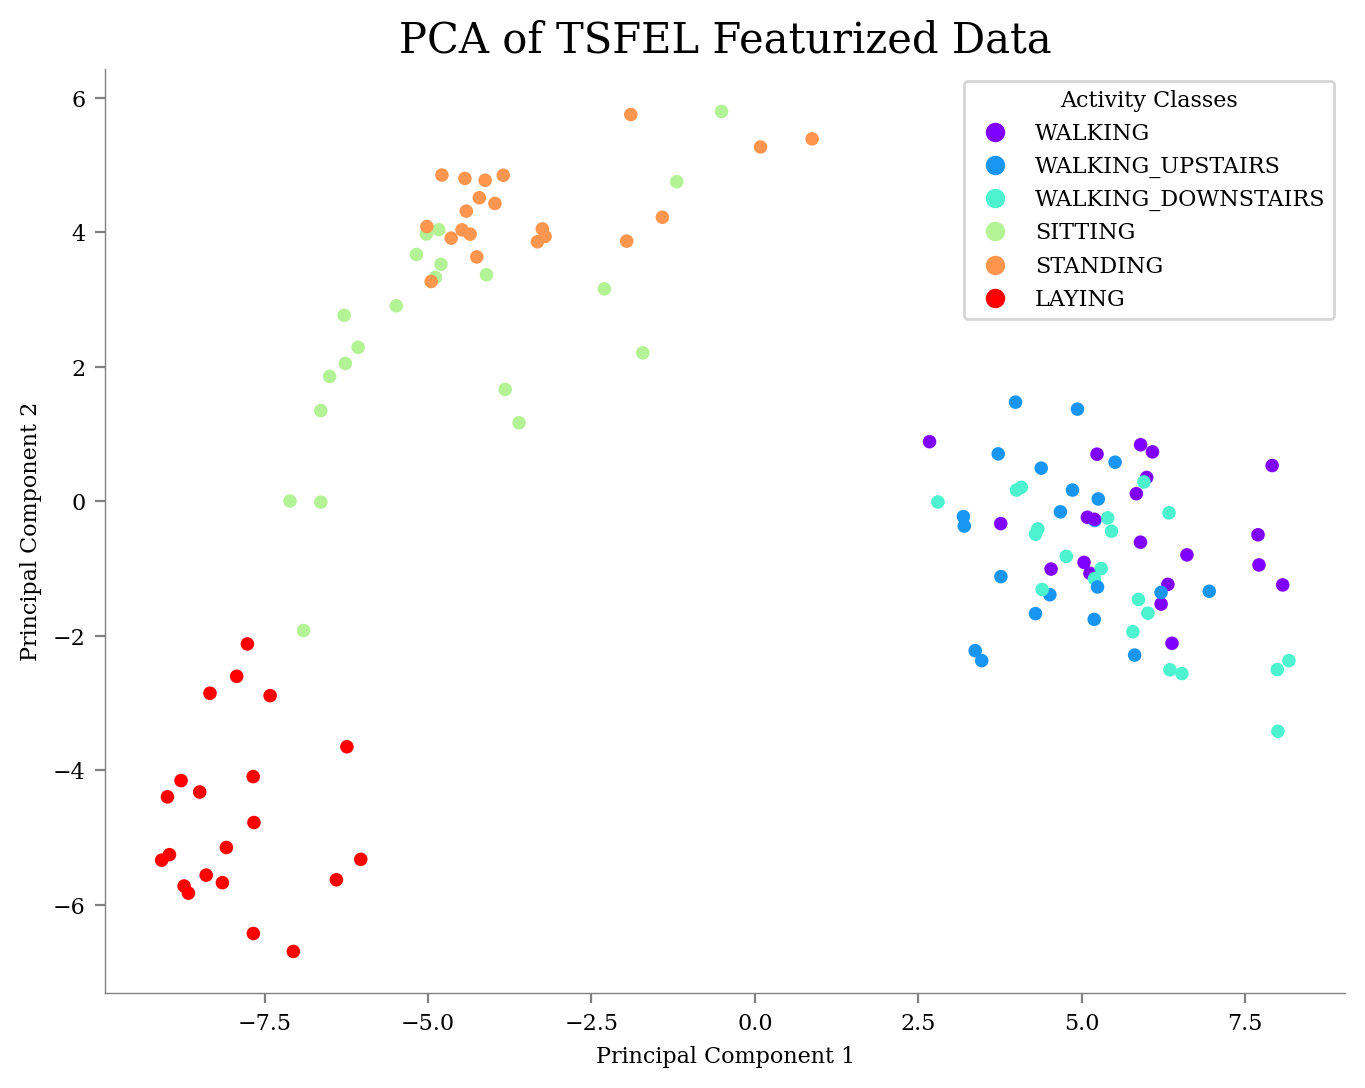

In [13]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_train_tsfel_pca[:, 0], X_train_tsfel_pca[:, 1], c=y_train, cmap='rainbow', s=15)
format_axes(plt.gca())
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of TSFEL Featurized Data", fontsize=15)
plt.legend(handles=scatter.legend_elements()[0], labels=activity_classes.keys(), title="Activity Classes")
if not os.path.exists('./Saved_Images'):
    os.makedirs('./Saved_Images')
plt.savefig('./Saved_Images/PCA_TSFEL_Data.png', bbox_inches='tight', dpi=300)
plt.show()

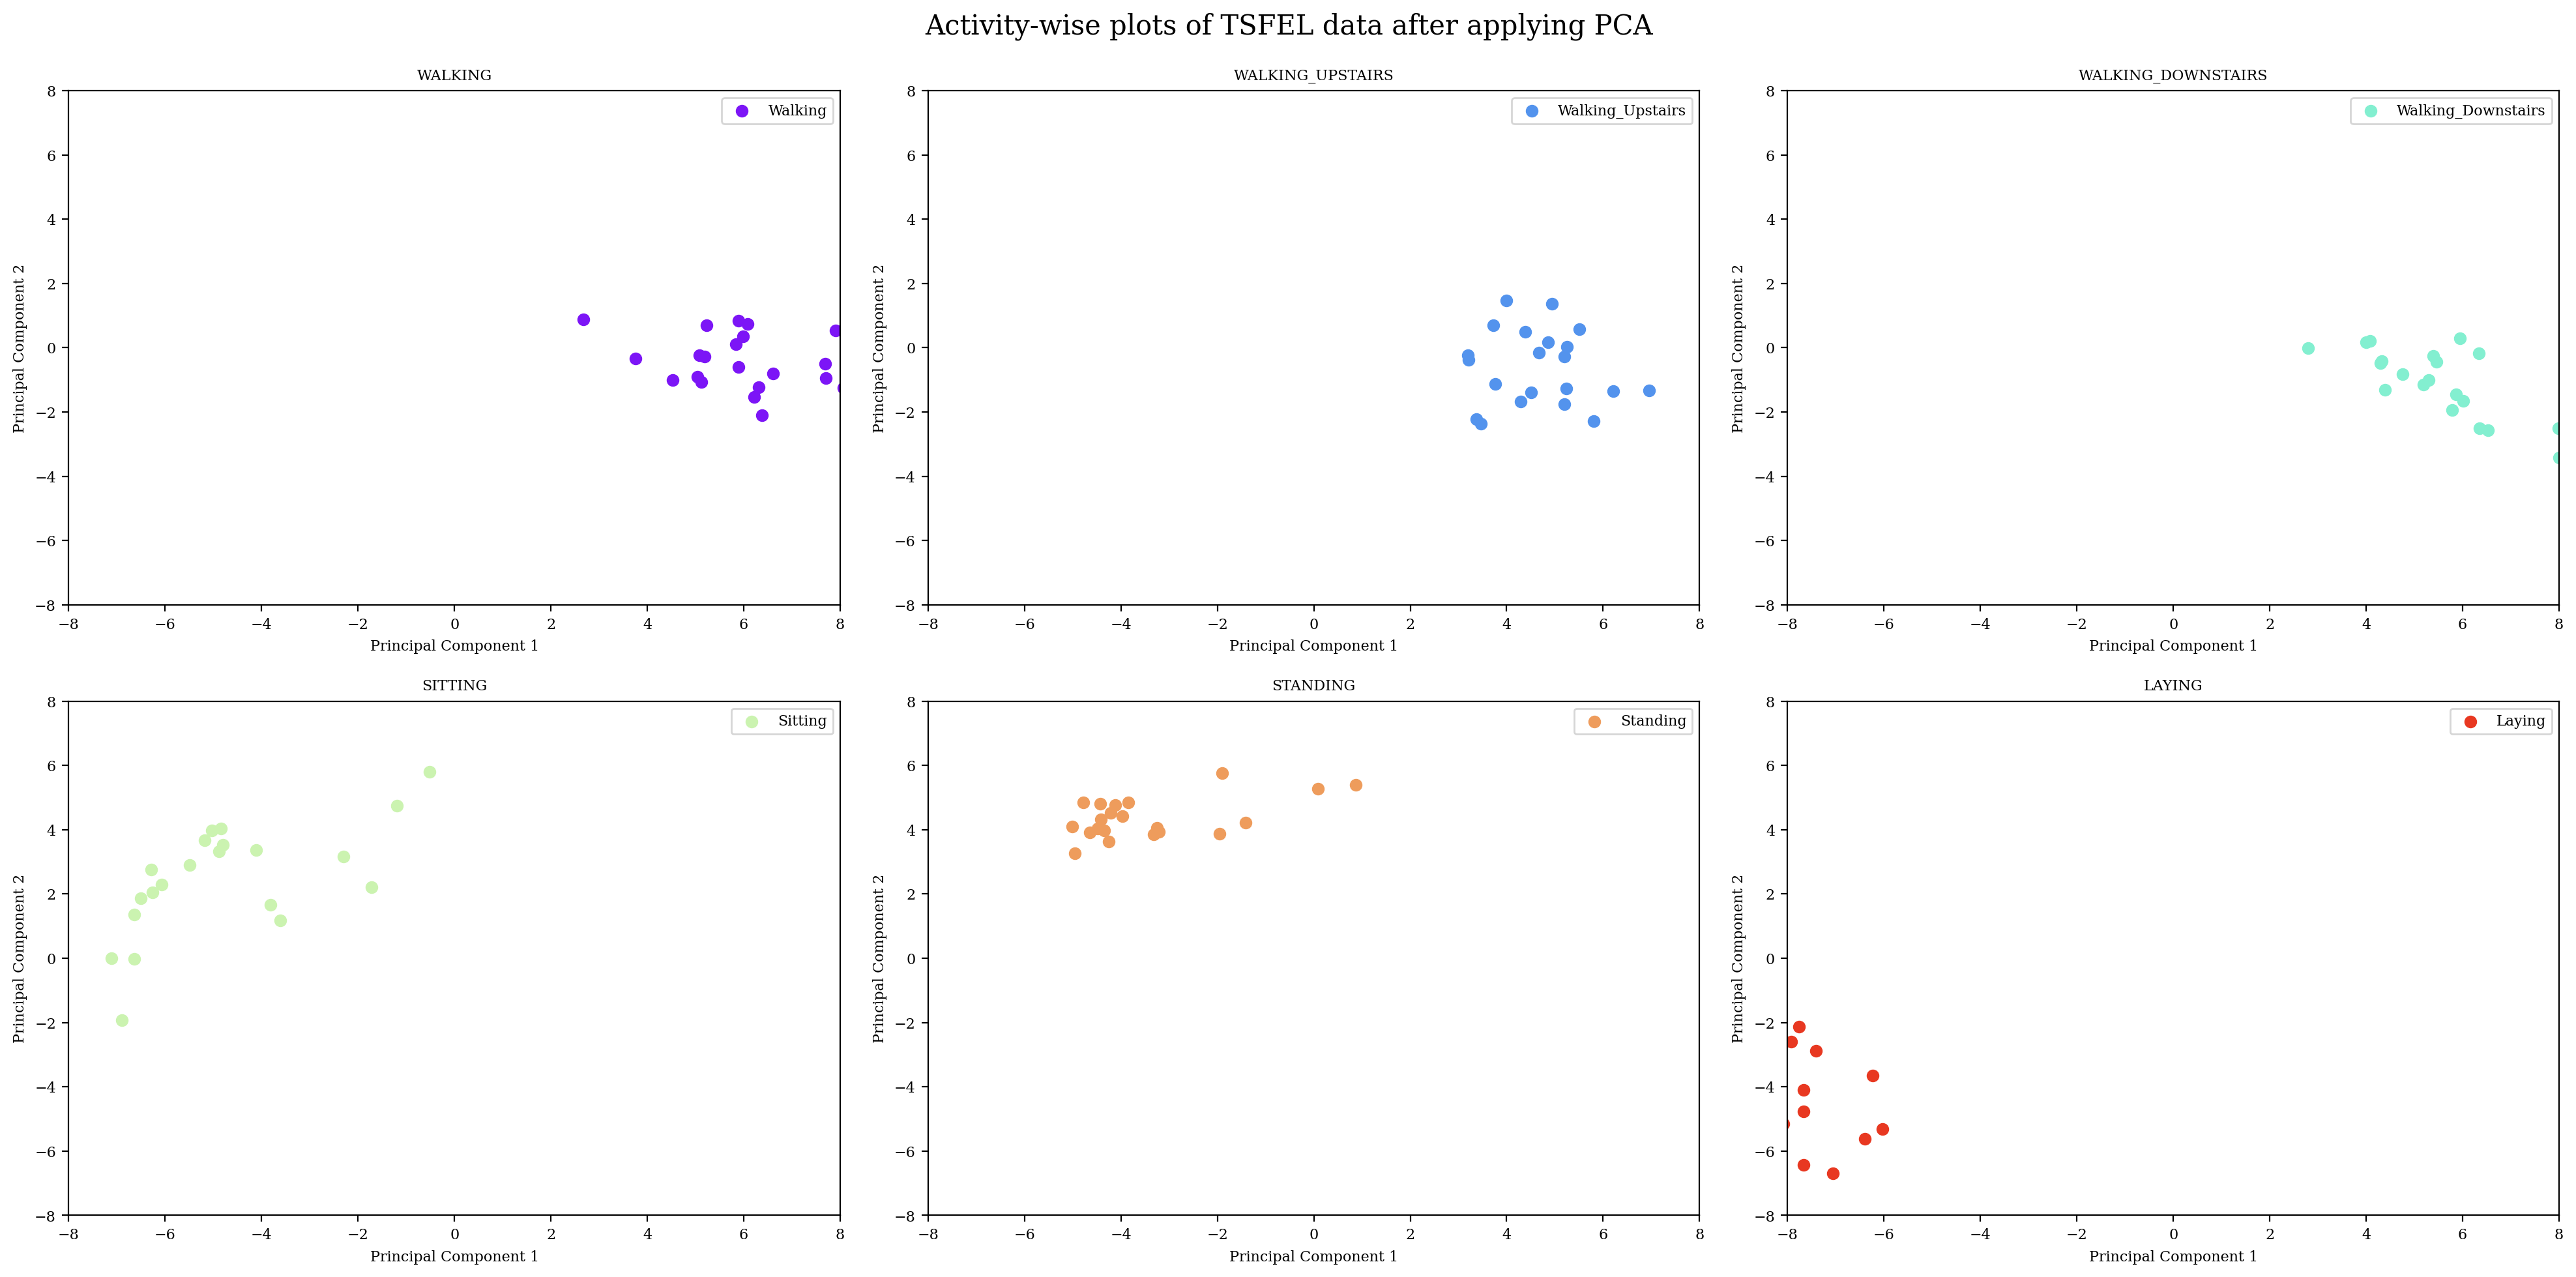

In [14]:
# now plot all different classes on each subplot
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle("Activity-wise plots of TSFEL data after applying PCA", fontsize=15)
axes = axes.flatten()
colors = ['#7c15f6','#5393ed','#83efd0','#cbf3b0','#ee9c5c','#e83821']

for activity_class, i in activity_classes.items():
    X_train_tsfel_pca_class = X_train_tsfel_pca[y_train == i]

    ax = axes[i-1]
    scatter = ax.scatter(X_train_tsfel_pca_class[:, 0], X_train_tsfel_pca_class[:, 1], c=colors[i-1], label=f'{str.title(activity_class)}')
    ax.set_title(f'{activity_class}')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_xlim(-8, 8)
    ax.set_ylim(-8, 8)
    ax.legend()

plt.tight_layout(pad=2.0)
plt.show()

In [15]:
pca_components = tsfel_pca.components_ # Get the PCA components

pca_components_df = pd.DataFrame(pca_components)

print("Loadings for the first principal component:")
print(pca_components_df.iloc[0])

print("Loadings for the second principal component:")
print(pca_components_df.iloc[1])

Loadings for the first principal component:
0      0.126790
1     -0.048641
2      0.013333
3      0.160991
4     -0.055700
         ...   
111   -0.027395
112    0.130677
113   -0.031465
114   -0.009544
115    0.124992
Name: 0, Length: 116, dtype: float64
Loadings for the second principal component:
0      0.206322
1     -0.000211
2      0.038351
3     -0.064524
4     -0.124989
         ...   
111    0.051141
112    0.162960
113    0.221706
114   -0.059105
115   -0.043928
Name: 1, Length: 116, dtype: float64


#### 3.3 Using the features provided by the dataset, perform PCA to obtain two features and then plotting the data

Run the `UCI_preprocess.py`, present in the current directory to extract the UCI HAR data.

In [16]:
UCI_X_train = np.load('../Saved_Datasets/UCI_561/UCI_X_train.npy')
UCI_X_test = np.load('../Saved_Datasets/UCI_561/UCI_X_test.npy')
UCI_y_train = np.load('../Saved_Datasets/UCI_561/UCI_y_train.npy')
UCI_y_test = np.load('../Saved_Datasets/UCI_561/UCI_y_test.npy')

print("Training data shape: ",UCI_X_train.shape)
print("Training labels shape: ",UCI_y_train.shape)
print("Testing data shape: ",UCI_X_test.shape)
print("Testing labels shape: ",UCI_y_test.shape)

Training data shape:  (7352, 561)
Training labels shape:  (7352, 1)
Testing data shape:  (2947, 561)
Testing labels shape:  (2947, 1)


In [17]:
uci_scaler = StandardScaler()
UCI_X_train_scaled = uci_scaler.fit_transform(UCI_X_train)
UCI_X_test_scaled = uci_scaler.transform(UCI_X_test)

uci_pca = PCA(n_components=2)
UCI_X_train_pca = uci_pca.fit_transform(UCI_X_train_scaled)
UCI_X_test_pca = uci_pca.transform(UCI_X_test_scaled)

print("Training data shape after PCA: ",UCI_X_train_pca.shape)
print("Testing data shape after PCA: ",UCI_X_test_pca.shape)

Training data shape after PCA:  (7352, 2)
Testing data shape after PCA:  (2947, 2)


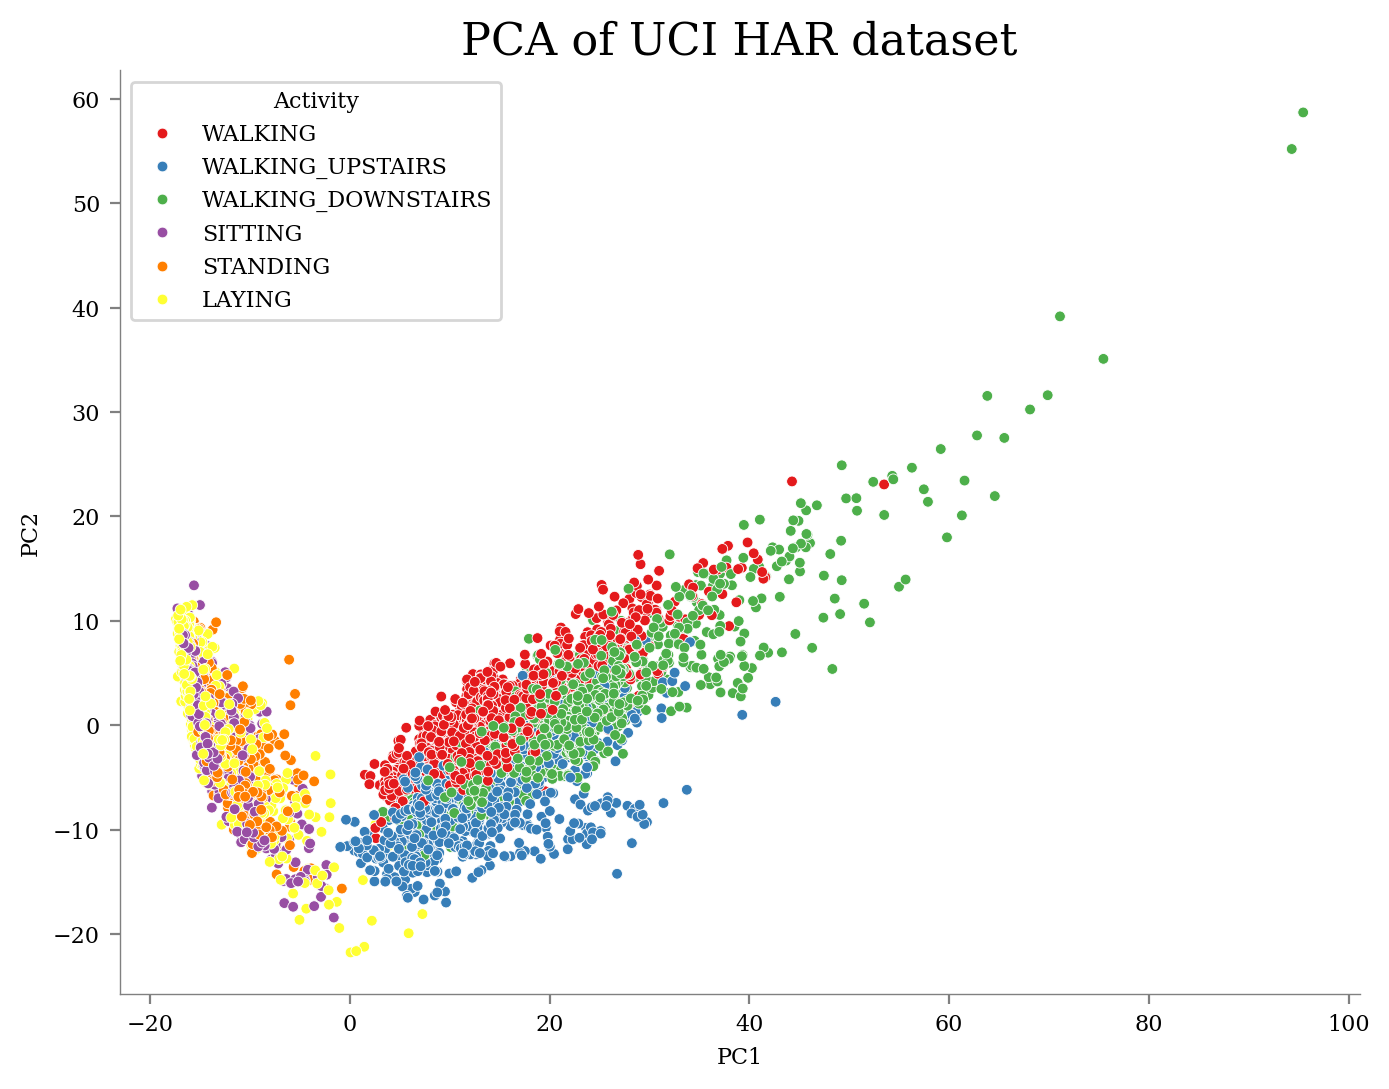

In [18]:
df_train = pd.DataFrame(UCI_X_train_pca,columns=["PC1","PC2"])
df_train["Activity"] = UCI_y_train
df_train["Activity"] = df_train["Activity"].map({1:"WALKING",2:"WALKING_UPSTAIRS",3:"WALKING_DOWNSTAIRS",4:"SITTING",5:"STANDING",6:"LAYING"})

plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", hue="Activity", data=df_train, palette="Set1", hue_order=["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"], s=15)
format_axes(plt.gca())
plt.title("PCA of UCI HAR dataset", fontsize=16)

if not os.path.exists('./Saved_Images'):
    os.makedirs('./Saved_Images')
plt.savefig('./Saved_Images/PCA_UCI_Data.png', bbox_inches='tight', dpi=300)
plt.show()

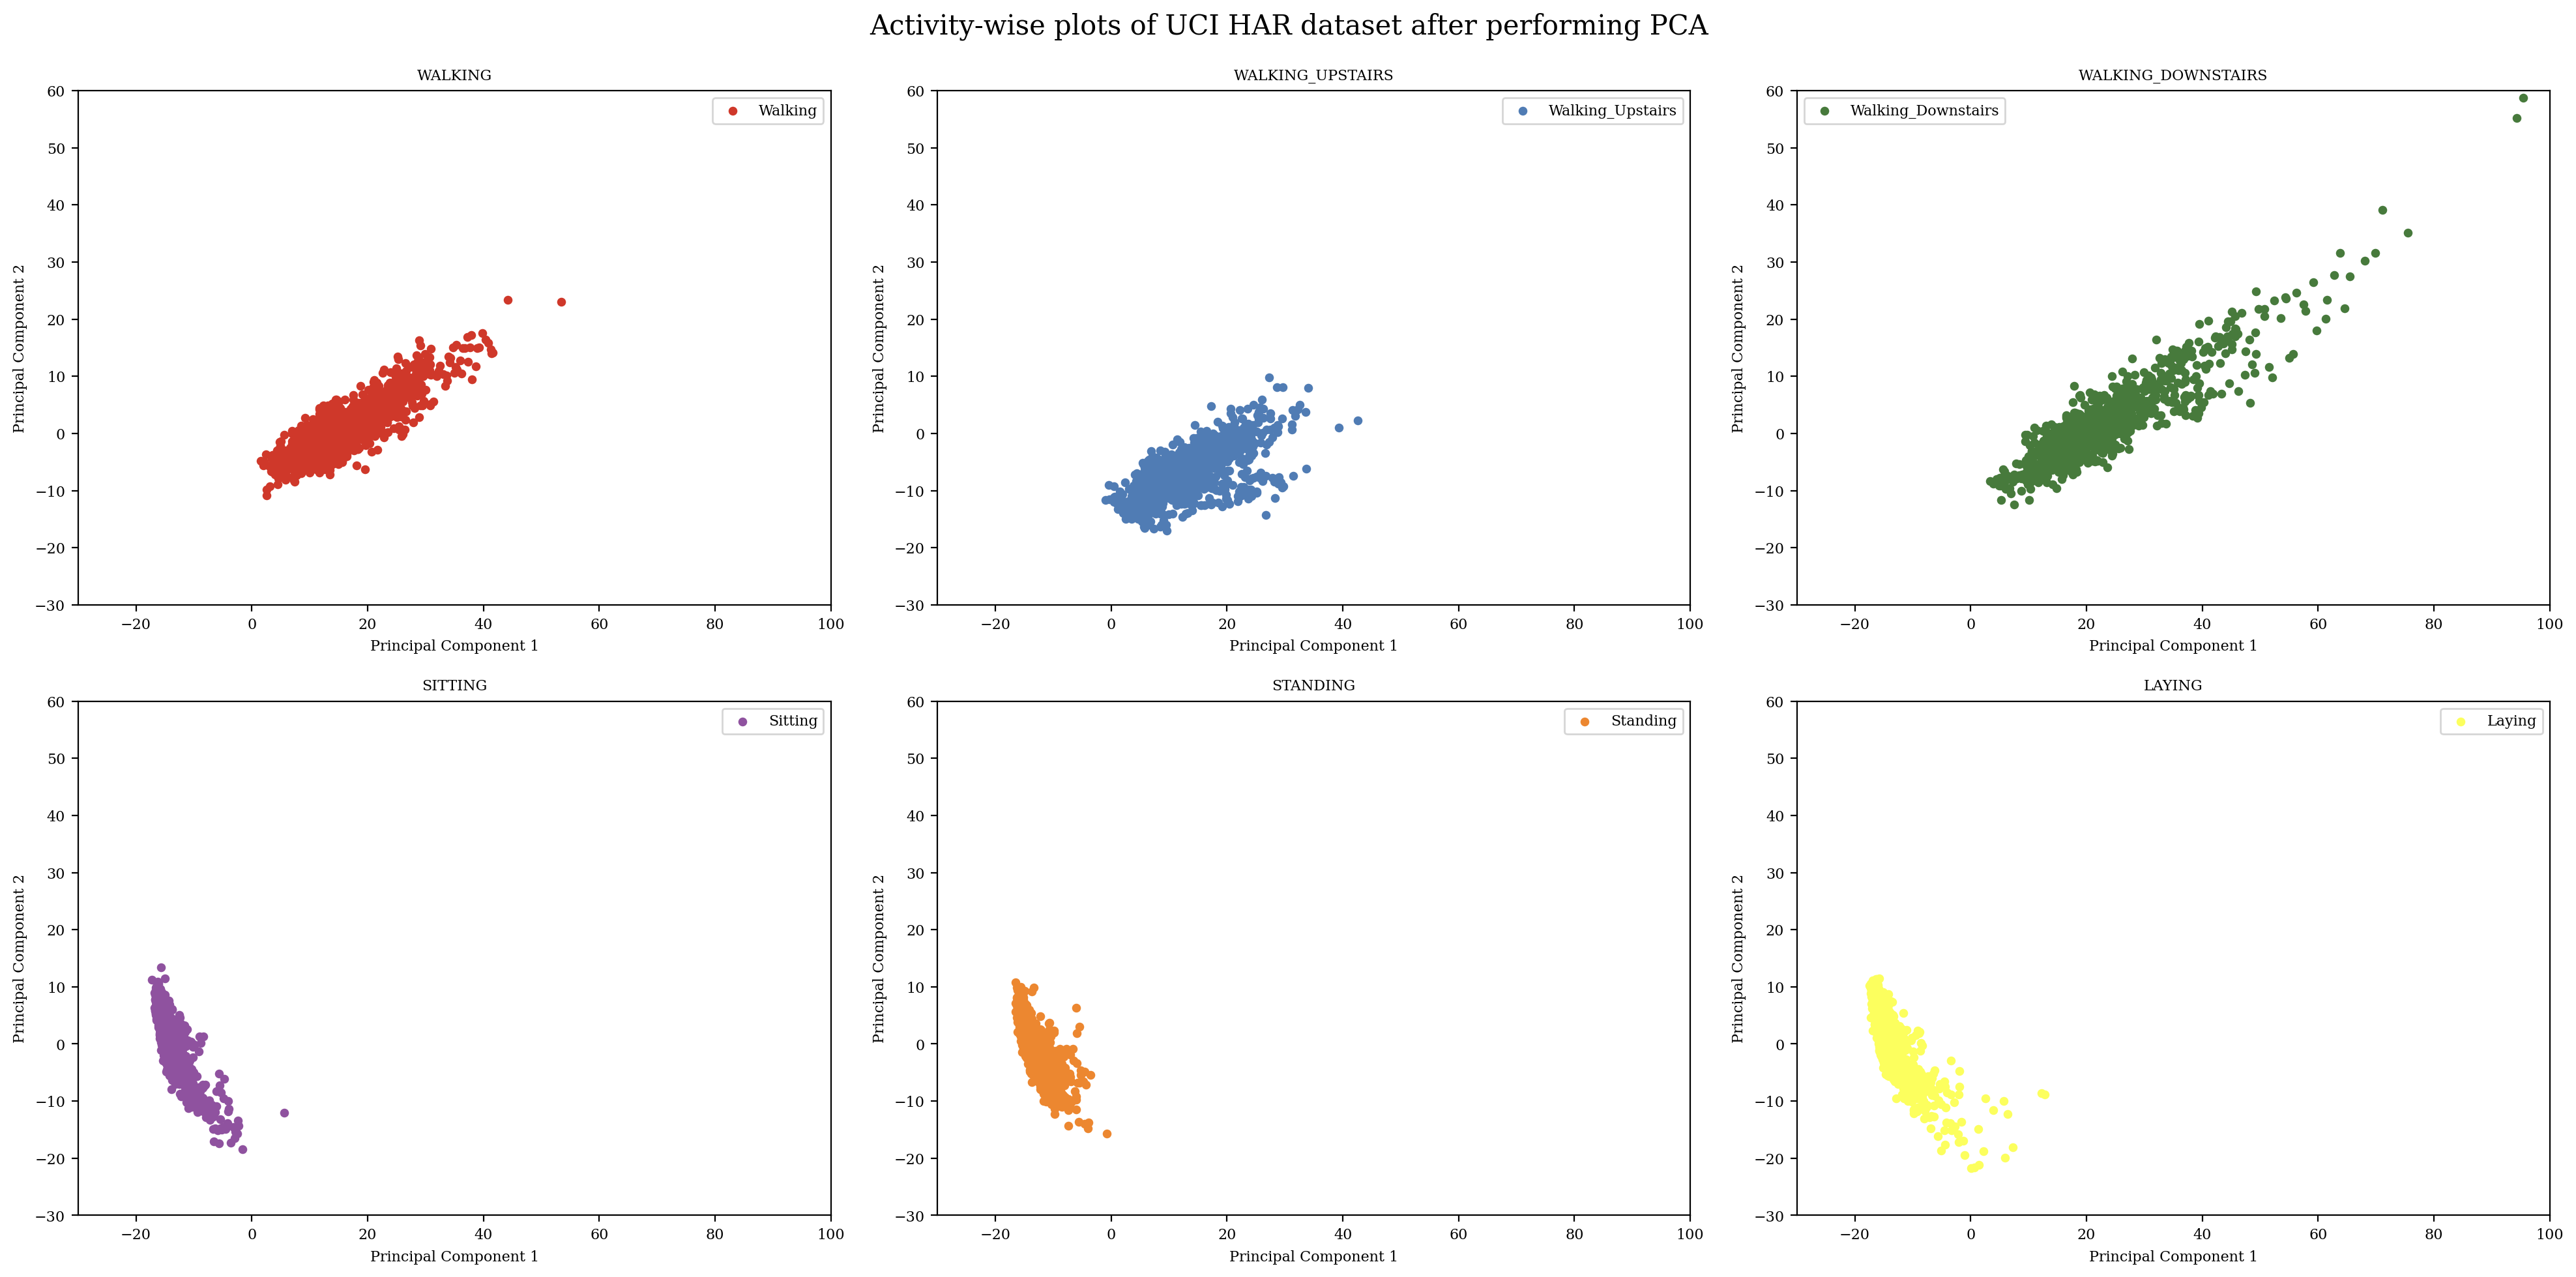

In [19]:
# plot all this classes separately
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle("Activity-wise plots of UCI HAR dataset after performing PCA", fontsize=15)
axes = axes.flatten()
colors = ['#cf382a','#507cb4','#477a3c','#8f529f','#ec8730','#fcff5e']

for activity_class, i in activity_classes.items():
    UCI_X_train_pca_class = df_train[df_train["Activity"] == activity_class][["PC1","PC2"]].values

    ax = axes[i-1]
    scatter = ax.scatter(UCI_X_train_pca_class[:, 0], UCI_X_train_pca_class[:, 1], c=colors[i-1], label=f'{str.title(activity_class)}', s=15)
    ax.set_title(f'{activity_class}')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_xlim(-30, 100)
    ax.set_ylim(-30, 60)
    ax.legend()

plt.tight_layout(pad=2.0)
plt.show()

In [20]:
pca_components = uci_pca.components_ # Get the PCA components

pca_components_df = pd.DataFrame(pca_components)

print("Loadings for the first principal component:")
print(pca_components_df.iloc[0])

print("Loadings for the second principal component:")
print(pca_components_df.iloc[1])

Loadings for the first principal component:
0      0.000028
1     -0.002473
2     -0.001527
3      0.056213
4      0.056788
         ...   
556    0.001014
557   -0.001582
558   -0.023100
559    0.029719
560    0.026622
Name: 0, Length: 561, dtype: float64
Loadings for the second principal component:
0      0.015638
1     -0.000080
2     -0.004052
3     -0.011165
4     -0.025959
         ...   
556    0.012141
557   -0.008723
558    0.017476
559   -0.035213
560   -0.017278
Name: 1, Length: 561, dtype: float64


### 3.4 Compare the results of PCA on Total Acceleration, TSFEL and the dataset features. Which method do you think is better for visualizing the data?

### Comparison of PCA Results

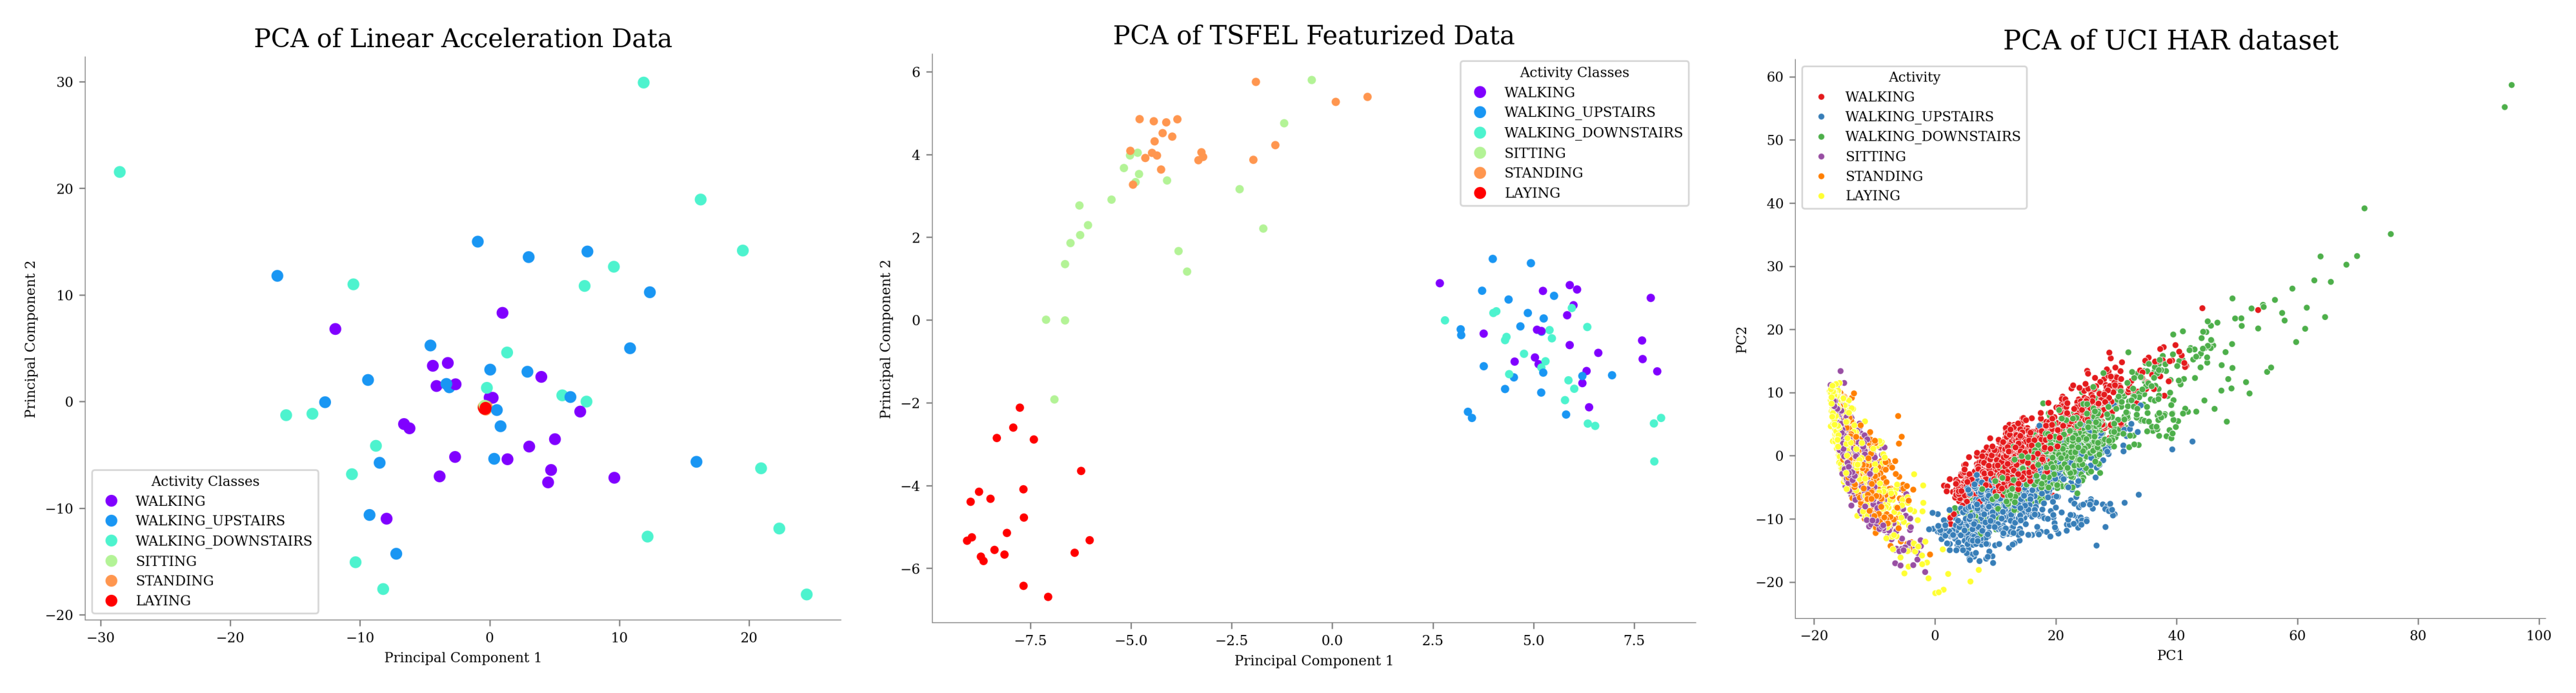

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes = axes.flatten()

plt.subplot(1, 3, 1)
img1 = plt.imread('./Saved_Images/PCA_Linear_Acceleration.png')
plt.imshow(img1)
plt.axis('off')

plt.subplot(1, 3, 2)
img2 = plt.imread('./Saved_Images/PCA_TSFEL_Data.png')
plt.imshow(img2)
plt.axis('off')

plt.subplot(1, 3, 3)
img3 = plt.imread('./Saved_Images/PCA_UCI_Data.png')
plt.imshow(img3)
plt.axis('off')

plt.tight_layout(h_pad=0.25)
plt.show()

1. **Total Acceleration:**
   - The scatter plot for PCA on Total Acceleration (computed as $(\sqrt{acc_x^2 + acc_y^2 + acc_z^2 })$) shows significant overlap among static activities (sitting, standing, laying) around the origin (approximately at (0, 0)).
   - This overlap occurs because static activities have almost constant linear acceleration close to 1 g, leading to minimal variability in the Total Acceleration feature. As a result, PCA projects these nearly constant values to a central point (0,0) in the principal component space, causing clustering. In contrast, dynamic activities (walking, walking upstairs, walking downstairs) exhibit greater variability in acceleration x,y ,z, causing them to be more dispersed across the principal component space. This dispersion reflects their higher variability and different movement patterns.

2. **TSFEL Features:**
   - The scatter plot for PCA on features extracted using TSFEL shows that static activities (sitting, standing, laying) are more clearly separated.
   - This separation is due to TSFEL extracting a variety of features that capture different aspects of the data, such as mean on each axis,  which better differentiate between static activities. Dynamic activities, however, still exhibit some overlap. This is likely because TSFEL features, while more informative than raw Total Acceleration, may not fully capture the nuances between different dynamic activities (walking, walking upstairs, walking downstairs), leading to partial overlap.

3. **Original Dataset Features:**
   - The scatter plot for PCA on the original dataset features reveals that static and dynamic activities can still be distinguished. However, there is considerable overlap among dynamic activities (walking, walking upstairs, walking downstairs), indicating that their clusters are not as distinct as expected.
   - This overlap might be due to the original features not sufficiently capturing the distinct characteristics of each dynamic activity or because the dynamic activities themselves have similar patterns of acceleration and thus are close to each other in the feature space.

### Conclusion
- **Total Acceleration** struggles with distinguishing among  activities,static activities are collapsed to a point ,wheareas dynamic activities are dispersed with no clear pattern.
- **TSFEL Features** offer better differentiation between static and dynamic activities ,provides clear differentitation between sitting,standing and laying .Shows some separation among dynamic activities, though overlap remains.
- **Original Dataset Features** also helps in distinguishing static from dynamic activities but with significant overlap among dynamic classes.

Overall, **TSFEL features** seem to provide the most informative representation for visualizing the data, as they offer a clearer boundary between static and dynamic activities and show some separation among dynamic activities.




## Question 4

Q4. Calculate the correlation matrix of the features obtained by TSFEL and provided in the dataset. Identify the features that are highly correlated with each other. Are there any redundant features?

**Solution:**

### Correlation matrix of features obtained from TSFEL data:

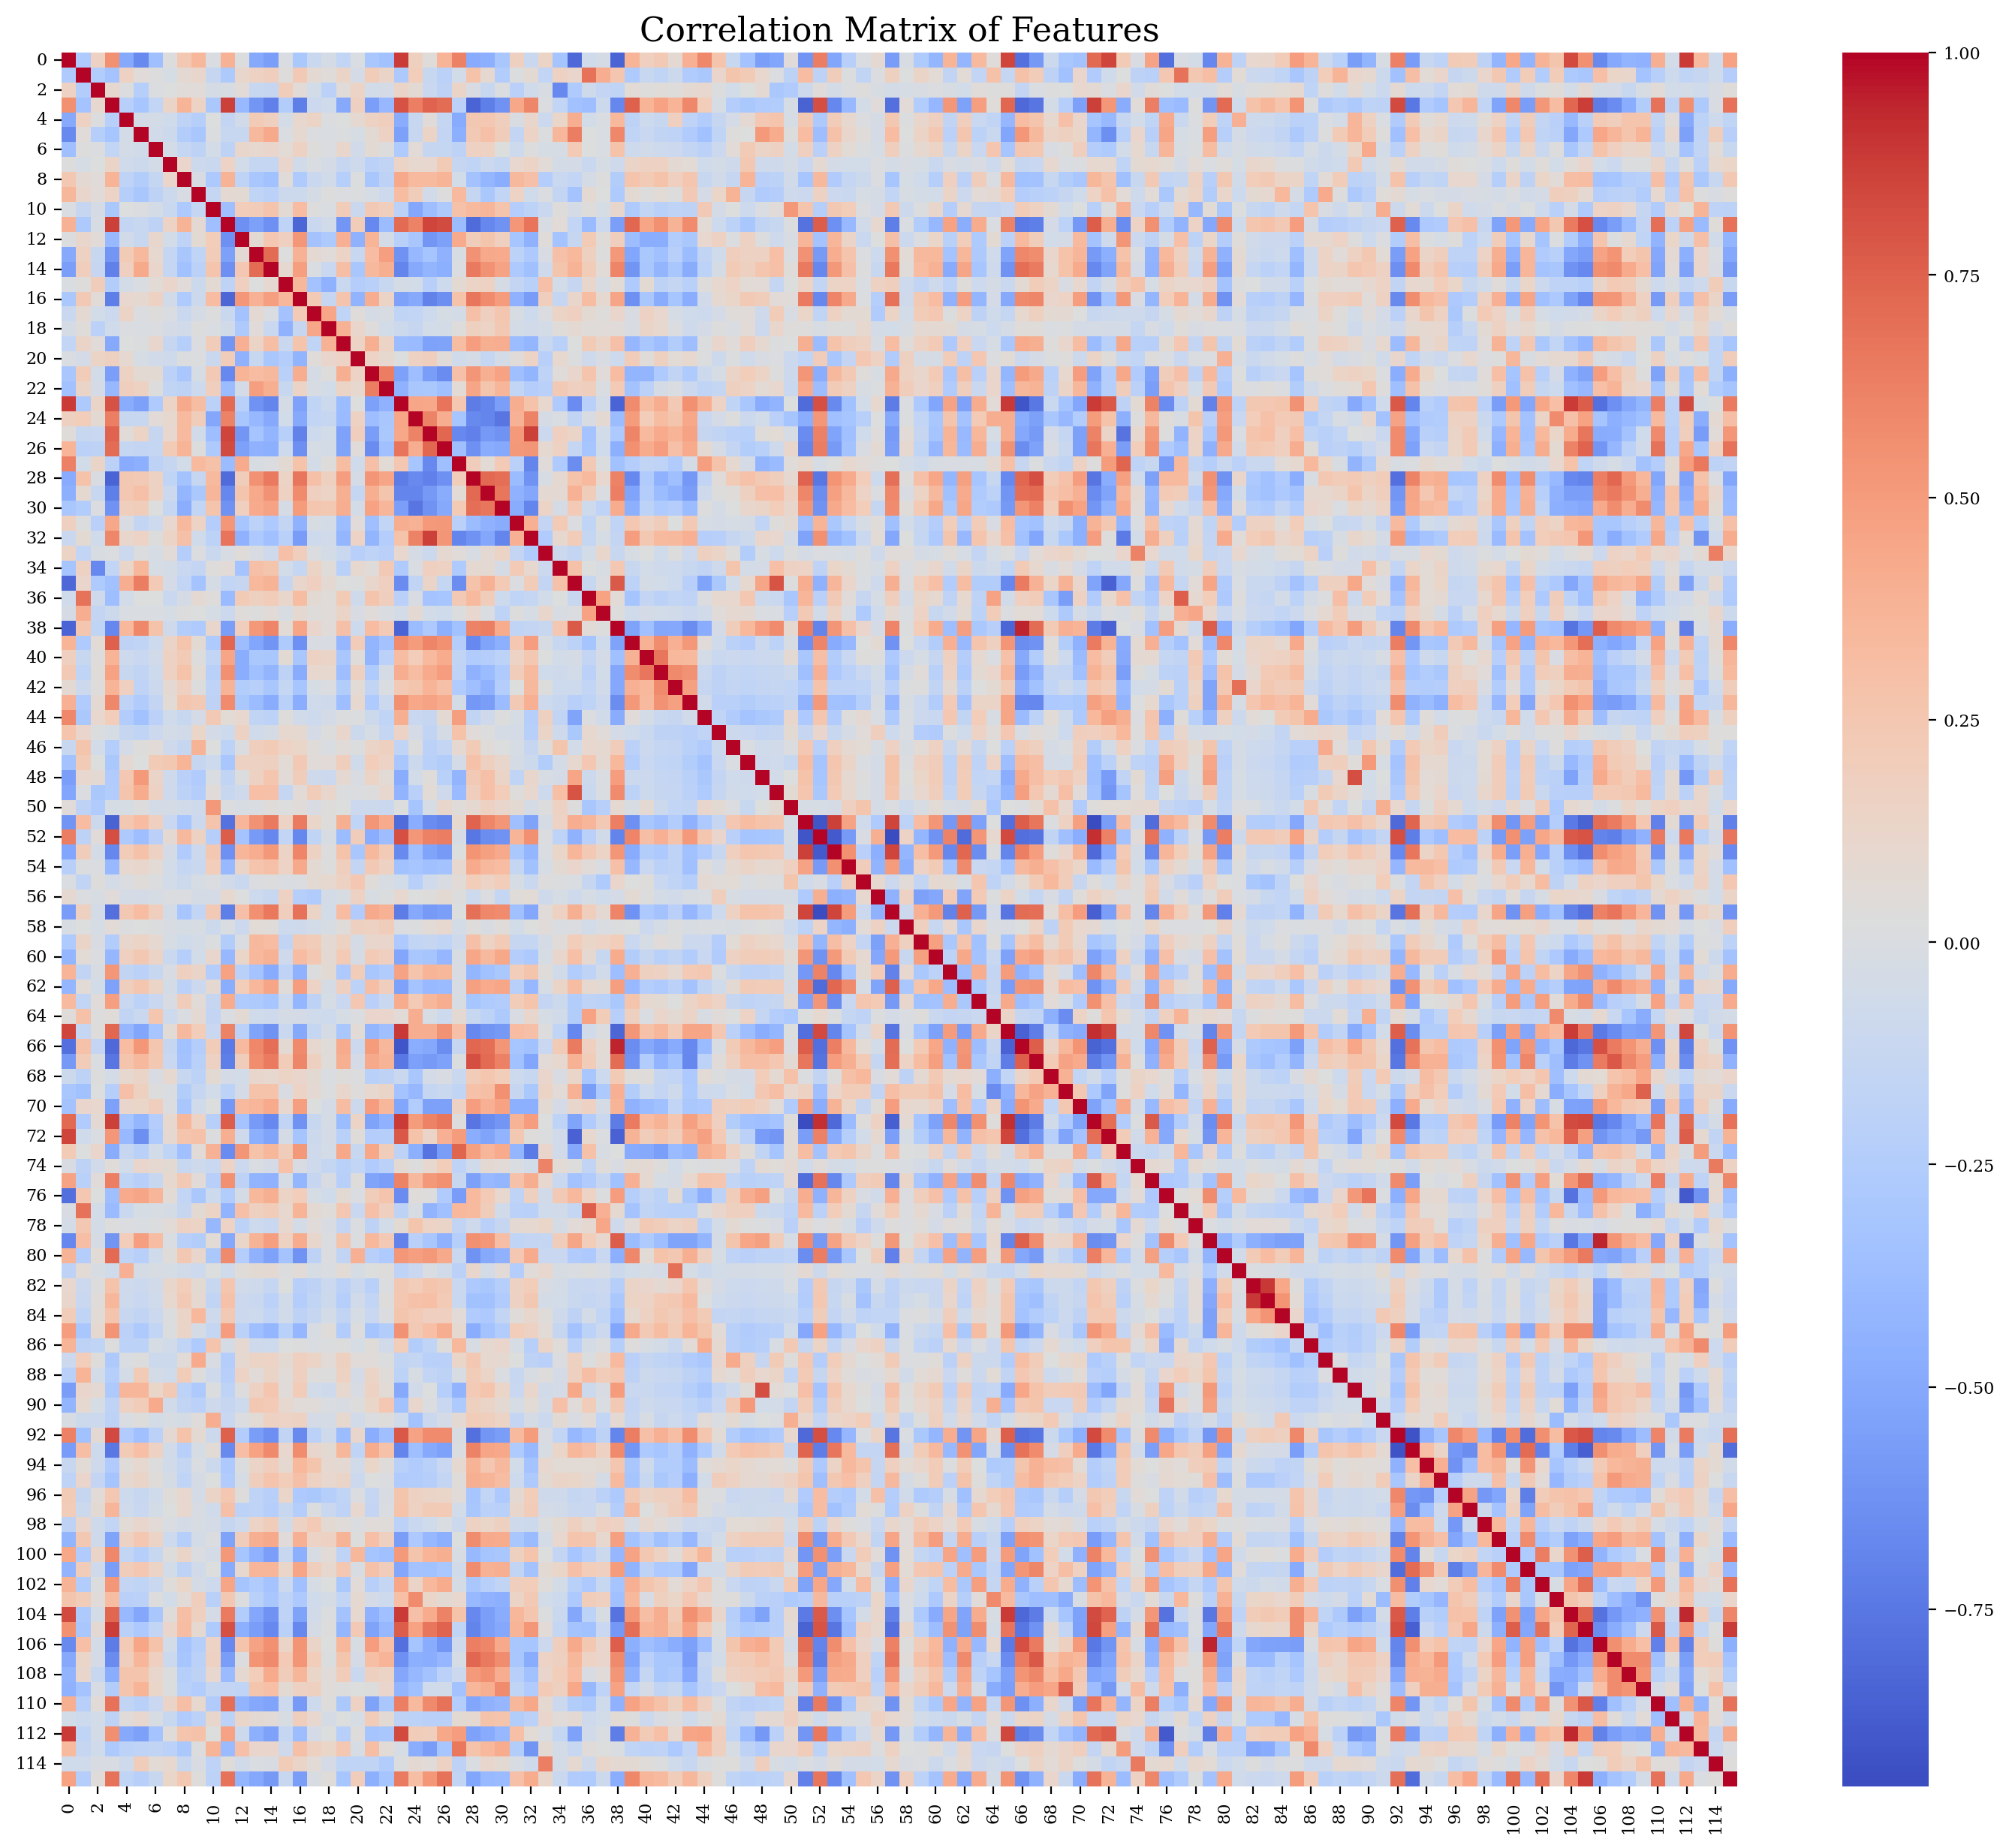

Number of highly correlated features:  30
Highly correlated features:  {11, 16, 23, 25, 26, 28, 32, 35, 38, 51, 52, 53, 57, 62, 65, 66, 67, 71, 72, 75, 83, 89, 92, 93, 101, 104, 105, 106, 112, 115}


In [22]:
X_train_tsfel_corr_var = pd.DataFrame(X_train_tsfel_corr_var)
corr_matrix = X_train_tsfel_corr_var.corr()

plt.figure(figsize=(18, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Correlation Matrix of Features", fontsize=16)
plt.show()

# Identify the features that are highly correlated with each other
corr_threshold = 0.8
highly_correlated_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            colname = corr_matrix.columns[i]
            highly_correlated_features.add(colname)

print("Number of highly correlated features: ", len(highly_correlated_features))
print("Highly correlated features: ", highly_correlated_features)

### Correlation matrix of 561 feautres obtained from the UCI HAR dataset:

No of Features: 561


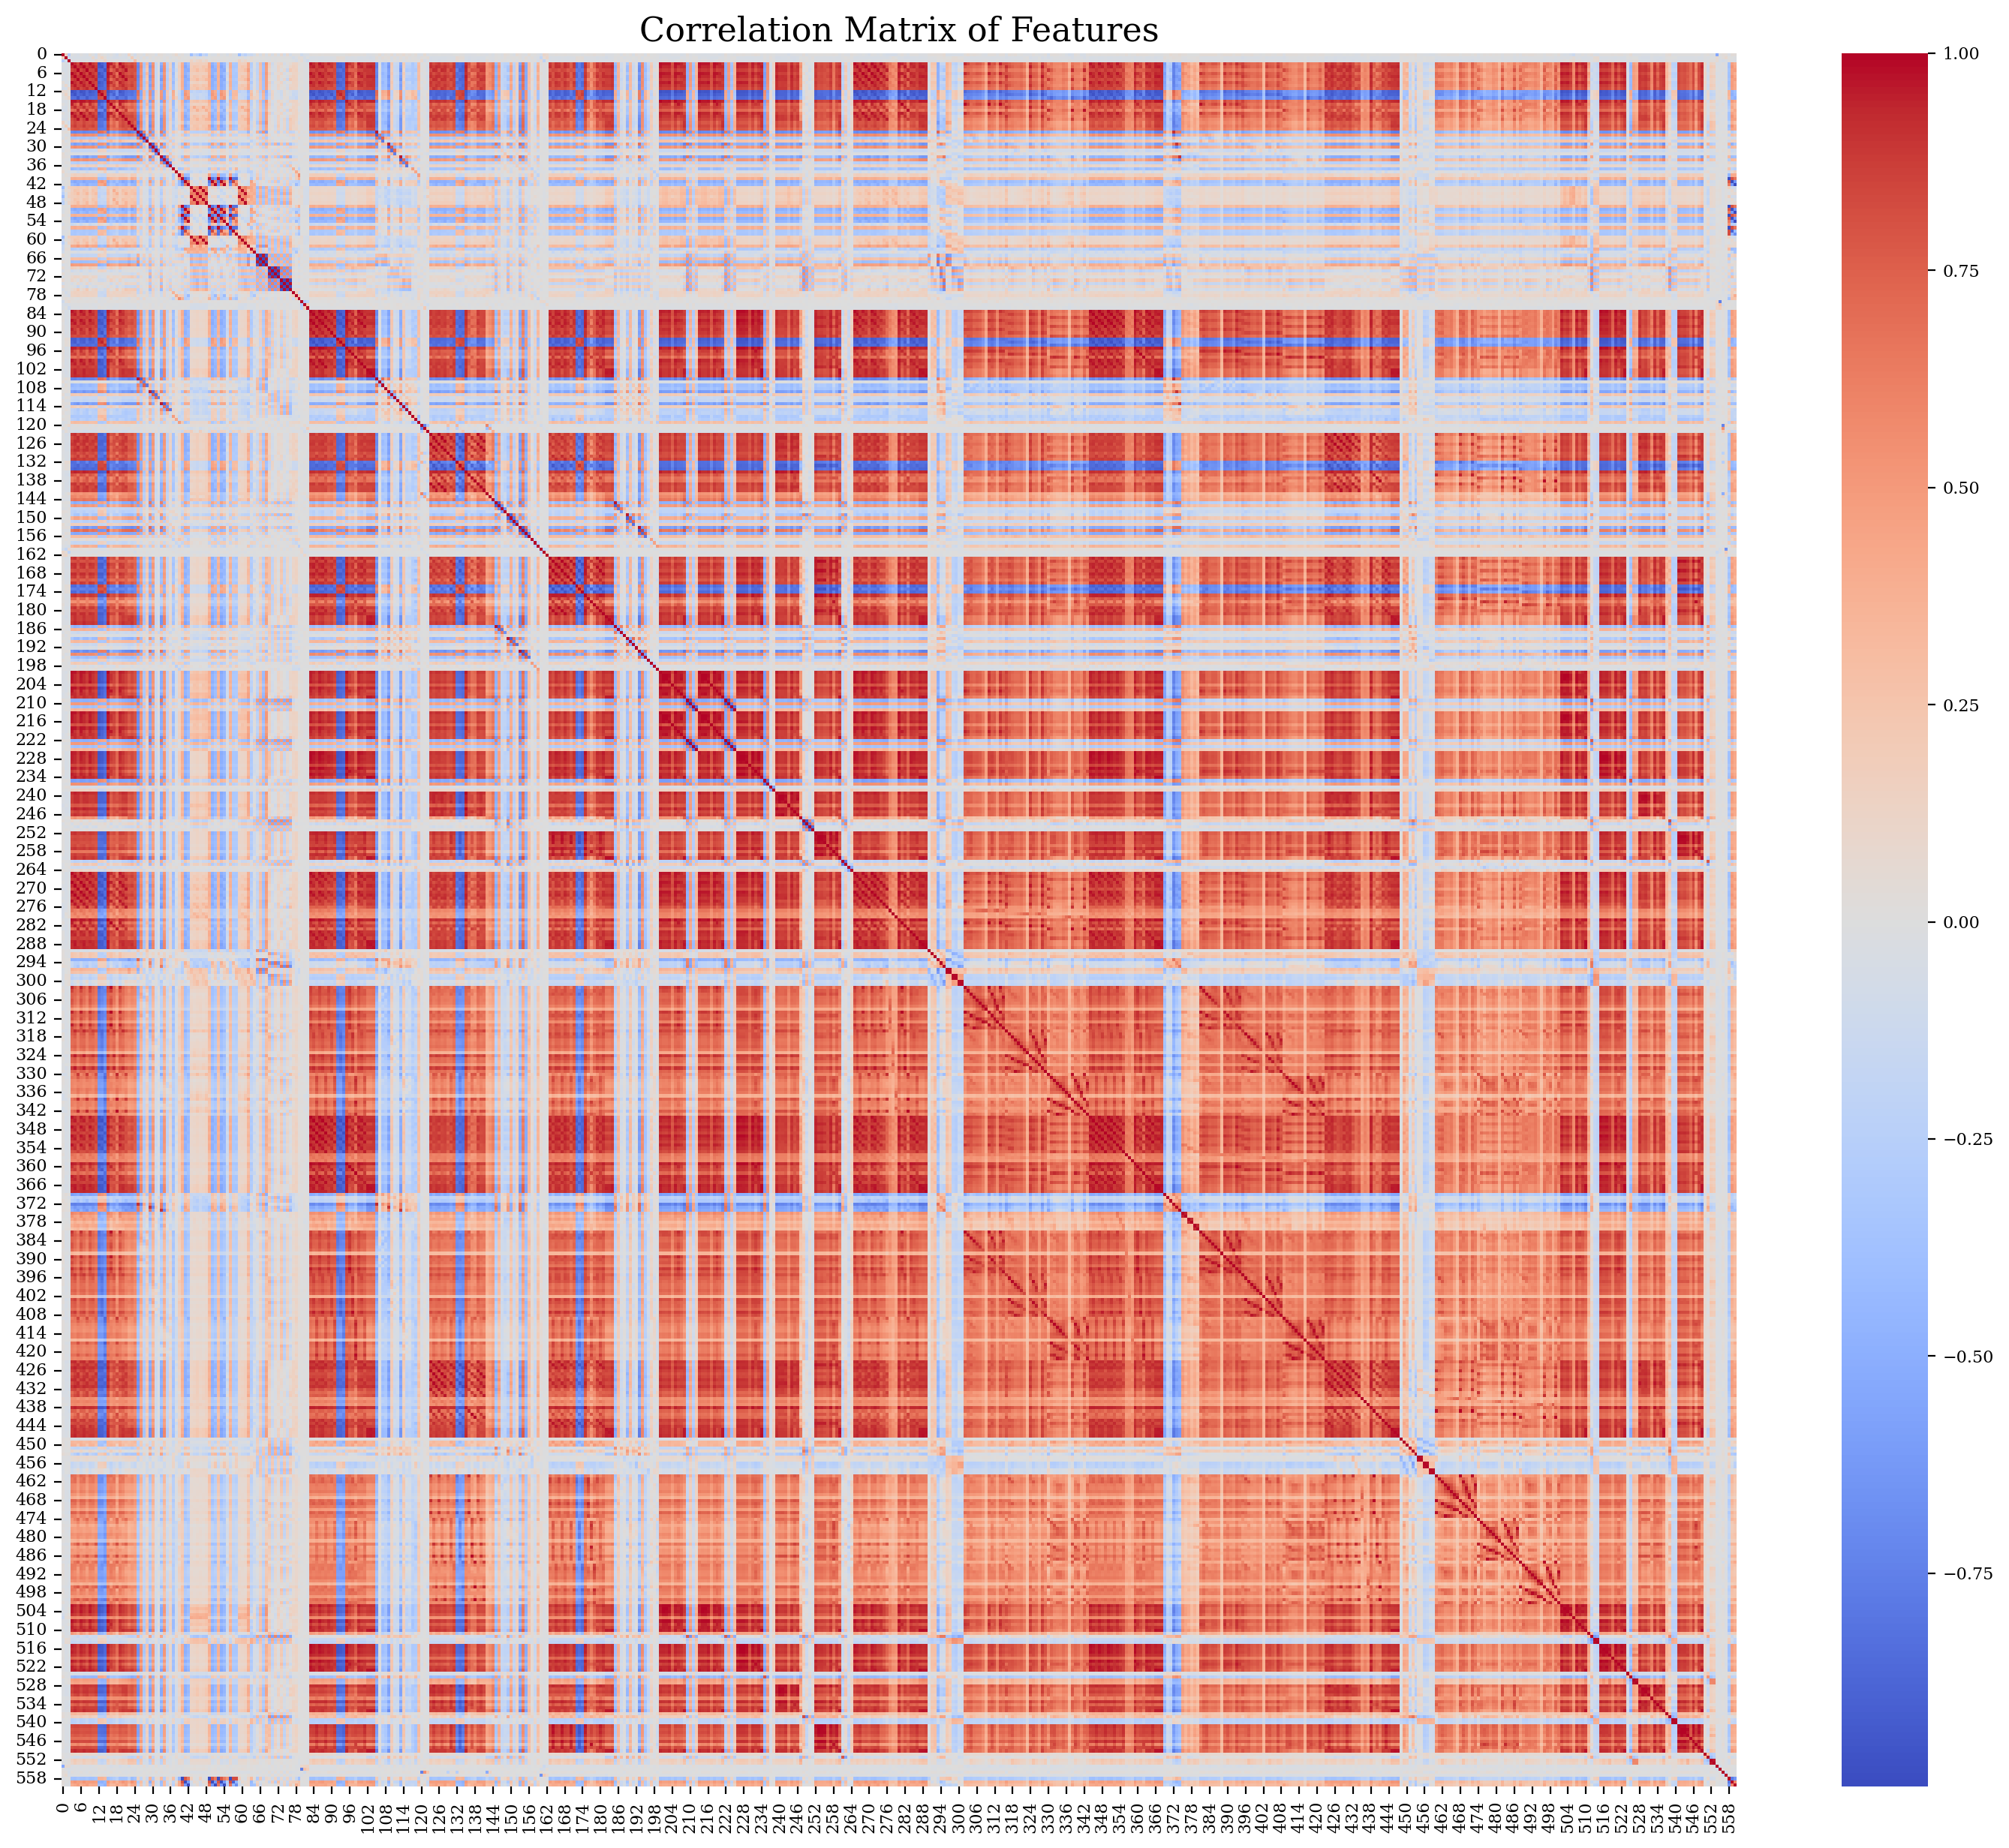

Number of highly correlated features: 338
Highly correlated features: {'tBodyGyroJerk-max()-Z', 'fBodyGyro-bandsEnergy()-17,32', 'fBodyBodyAccJerkMag-entropy()', 'tBodyGyroJerk-entropy()-X', 'tBodyGyroJerk-min()-X', 'tBodyAcc-std()-Y', 'tBodyGyro-iqr()-X', 'tBodyAccJerk-max()-X', 'tBodyAccJerk-entropy()-Z', 'tBodyGyroJerk-arCoeff()-Z,1', 'tBodyAccMag-energy()', 'tBodyGyroJerk-mad()-Y', 'tBodyGyroJerk-std()-Y', 'tBodyGyroMag-arCoeff()2', 'fBodyAcc-std()-X', 'fBodyAcc-iqr()-X', 'fBodyAccJerk-bandsEnergy()-41,48', 'fBodyGyro-mean()-Z', 'tBodyGyroJerk-sma()', 'tBodyGyro-energy()-X', 'fBodyAcc-bandsEnergy()-41,48', 'tBodyAcc-max()-Y', 'tBodyAcc-min()-Z', 'tBodyAccJerk-max()-Y', 'fBodyAccJerk-std()-Z', 'tBodyGyro-min()-Z', 'tBodyGyroJerkMag-iqr()', 'fBodyGyro-entropy()-X', 'fBodyGyro-std()-Y', 'fBodyAccJerk-kurtosis()-X', 'tBodyGyroJerk-entropy()-Y', 'fBodyAccMag-iqr()', 'tGravityAcc-iqr()-Y', 'fBodyAcc-bandsEnergy()-1,16', 'tBodyAccMag-sma()', 'tBodyAccJerkMag-energy()', 'fBodyAccJerk-bands

In [23]:
UCI_features = list()
with open('../UCI HAR Dataset/features.txt') as f:
    UCI_features = [line.split()[1] for line in f.readlines()]

print('No of Features: {}'.format(len(UCI_features)))

UCI_X_train = pd.DataFrame(UCI_X_train)
corr_matrix = UCI_X_train.corr()

plt.figure(figsize=(18, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Correlation Matrix of Features", fontsize=16)
plt.show()

corr_threshold = 0.8
highly_correlated_features = set()

# Find pairs of highly correlated features and store the names
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            colname = UCI_features[i]
            highly_correlated_features.add(colname)

# Print the highly correlated features
print("Number of highly correlated features:", len(highly_correlated_features))
print("Highly correlated features:", highly_correlated_features)